# Utility functions


In [1]:
%matplotlib inline
from nltk.cluster.kmeans import KMeansClusterer
import nltk
import pickle

import torch
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertPreTrainingHeads
import numpy as np
from scipy.spatial.distance import cosine
import pickle
import re
import pandas as pd
device = 'cuda'
import sys
import os
import iso8601
from datetime import datetime

import json
import string

In [2]:
class BertForPreTraining_custom(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPreTraining_custom, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        output_all_encoded_layers=True
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=output_all_encoded_layers)
        if output_all_encoded_layers:
            sequence_output_pred = sequence_output[-1]
        prediction_scores, seq_relationship_score = self.cls(sequence_output_pred, pooled_output)
        return prediction_scores, seq_relationship_score, sequence_output, pooled_output 
    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_json_file('../models/bert_config.json')
#config = BertConfig.from_json_file('../../../ai-engine/mind_files/bert_config.json')
bert_model = 'bert-base-uncased'

In [3]:
def getNSPScore(sample_text):
    
    m = torch.nn.Softmax()

    tokenized_text = tokenizer.tokenize(sample_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [0]*tokenized_text.index('[SEP]')+[1]*(len(tokenized_text)-tokenized_text.index('[SEP]'))

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    pred_score, seq_rel, seq_out, pool_out = model1(tokens_tensor, segments_tensors)
    return m(seq_rel).detach().numpy()[0][0] #returns probability of being next sentence

def getSentMatchScore(sent1, sent2, nsp_dampening_factor = 0.7):
    
    sent1_feats = getBERTFeatures(model1, sent1, attn_head_idx)
    sent2_feats = getBERTFeatures(model1, sent2, attn_head_idx)
    
    cosine_distance = 1- cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    #print ("nsp score -> " + str(nsp_score))
    #print ("cosine score -> " + str(cosine_distance))
    return score
    

def getSentMatchScore_wfeature(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    #nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    #nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = nsp_score_1 * nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score

def getSentMatchScore_wfeature_cosine(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    return cosine_distance
    

def getBERTFeatures(model, text, attn_head_idx = -1): #attn_head_idx - index o[]
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text)>200:
        tokenized_text = tokenized_text[0:200]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens]).cpu()
    _, _, seq_out, pool_out = model(tokens_tensor)
    seq_out = list(getPooledFeatures(seq_out[attn_head_idx]).T)
    #pool_out = list(pool_out.detach().numpy().T)
    
    return seq_out

def getPooledFeatures(np_array):
    np_array = np_array.reshape(np_array.shape[1],np_array.shape[2]).detach().numpy()
    np_array_mp = np.mean(np_array, axis=0).reshape(1, -1)
    return np_array_mp

def replaceContractions(text):
    #text = text.lower()
    c_filt_text = ''
    for word in text.split(' '):
        if word in contractions:
            c_filt_text = c_filt_text+' '+contractions[word]
        else:
            c_filt_text = c_filt_text+' '+word
    return c_filt_text

def cleanText(text):
        
    text = text.replace('\\n','')
    text = text.replace('\\','')
    #text = text.replace('\t', '')
    #text = re.sub('\[(.*?)\]','',text) #removes [this one]
    text = re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?\s',
                ' __url__ ',text) #remove urls
    #text = re.sub('\'','',text)
    #text = re.sub(r'\d+', ' __number__ ', text) #replaces numbers
    text = re.sub('\W', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    return text

def formatTime(tz_time, datetime_object=False):
    isoTime = iso8601.parse_date(tz_time)
    ts = isoTime.timestamp()
    ts = datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S:%f")

    if datetime_object:
        ts = datetime.fromisoformat(ts)
    return ts


In [4]:
# for USE testing
import boto3
from boto3 import client
from botocore.client import Config
aws_config = Config(
        connect_timeout=60,
        read_timeout=300,
        retries={"max_attempts": 0},
        region_name="us-east-1",
    )
lambda_client = client("lambda", config=aws_config)

def get_embeddings(input_list, req_data=None):

    if req_data is None:
        lambda_payload = {"body": {"text_input": input_list}}
    else:
        lambda_payload = {"body": {"request": req_data, "text_input": input_list}}

    try:
        #logger.info("Invoking lambda function")
        invoke_response = lambda_client.invoke(
            FunctionName="keyphrase_ranker",
            InvocationType="RequestResponse",
            Payload=json.dumps(lambda_payload),
        )

        lambda_output = (
            invoke_response["Payload"].read().decode("utf8").replace("'", '"')
        )
        response = json.loads(lambda_output)
        status_code = response["statusCode"]
        response_body = response["body"]

        if status_code == 200:
            embedding_vector = np.asarray(json.loads(response_body)["embeddings"])

        else:
            embedding_vector = np.asarray(json.loads(response_body)["embeddings"])
    except Exception as e:
        print (e)
        pass
    return embedding_vector

In [ ]:
# #c_text = "'Hi director technical product management."
# c_fv = getBERTFeatures(model1, "Youre be in our cloud hypotheses and and the session is all about giving days to you in five minutes and it is going to be a little bit of a challenge.", attn_head_idx = -1)
# c_fv2 = getBERTFeatures(model1, "So I am going have to brush over a lot of detailed concept.", attn_head_idx = -1)
# # getSentMatchScore_wfeature_cosine(c_text, c_text, c_fv, c_fv2, nsp_dampening_factor = 0.7)
# 1-cosine(c_fv,c_fv2)

In [5]:
model1 = BertForPreTraining_custom(config)
device='cpu'
model1.to(device)
#state_dict_1 = torch.load('../models/ml-ai.bin')
state_dict_1 = torch.load('../models/bert_10epc_se_1e-6_sl40.bin')
#state_dict_1 = torch.load('../models/mind-01daaqy88qzb19jqz5prjfr76y.bin')
model1.load_state_dict(state_dict_1)
model1.eval()

BertForPreTraining_custom(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): 

## Topic extraction with keyphrase approach as cosine similarity.

In [ ]:
def getKPBasedSimilarity(text1,text2,model=None,tup1=None,tup2=None,layer = -1):

    """
    Calculates similarity between two sentences - based on noun phrases, verb<>noun phrases. Calculates pair-wise cosine similarity between candidate phrases
    returns mean of top-3 similar phrases as similarity

    Args:
    text1: required 
    text2: required
    model optional, required if tup1 and tup2 are provided
    tup1: bert features of `sent1` as returned by getBERTFeatures()
    tup2: bert features of `sent2` as returned by getBERTFeatures()
    layer: optional, BERT layer to extract features from

    Output:
    returns key-phrase based cosine similarity between the sentences
    """

    #text1 = customPreprocess(text1)
    #text2 = customPreprocess(text2)

    if (tup1 is not None) and (tup2 is not None):
        token_feats_1,final_feats1,text1_bert_tokenized = tup1
        token_feats_2,final_feats2,text2_bert_tokenized = tup2
    else:
        if model is not None:
            token_feats_1,final_feats1,text1_bert_tokenized = getBERTFeatures(model, text1, attn_head_idx=layer)
            token_feats_2,final_feats2,text2_bert_tokenized = getBERTFeatures(model, text2, attn_head_idx=layer)
        else:
            assert model is not None

    text1_sent_tokens = tokenize(text1)
    text2_sent_tokens = tokenize(text2)

    merged_feats_text1 = getWordFeatsFromBertTokenFeats(text1_sent_tokens,text1_bert_tokenized,token_feats_1)
    merged_feats_text2 = getWordFeatsFromBertTokenFeats(text2_sent_tokens,text2_bert_tokenized,token_feats_2)

    #get candidate key-phrases for both sentences
    kps_sent1,kps_loc_sent1 = getCandidatePhrases(text1)
    kps_sent2,kps_loc_sent2 = getCandidatePhrases(text2)
    
    sent1_kp_feats = getKeyPhraseFeatures(kps_sent1,kps_loc_sent1,merged_feats_text1,text1_sent_tokens)
    sent2_kp_feats = getKeyPhraseFeatures(kps_sent2,kps_loc_sent2,merged_feats_text2,text2_sent_tokens)

    sim_list = []
    for sent1_kp, feats1 in zip(kps_sent1,sent1_kp_feats):
        for sent2_kp, feats2 in zip(kps_sent2,sent2_kp_feats):
            if len(sent1_kp.split(' '))+len(sent2_kp.split(' '))==2:
                if len(sent1_kp.split(' ')[0])<4 or len(sent2_kp.split(' ')[0])<4:
                    continue
                curr_sim = 1-spatial.distance.cosine(feats1,feats2)
            else:
                if len(sent1_kp.split(' '))==1 or len(sent2_kp.split(' '))==1:
                    continue
                else:
                    curr_sim = 1-spatial.distance.cosine(feats1,feats2)
            sim_list.append(curr_sim)

    if len(sim_list)>3:
        sim_list = sim_list[0:3]
    if len(sim_list)>0:
        mean_dist = np.mean(sim_list)
    else:
        mean_dist = 0.0
        
    return mean_dist


In [ ]:
## utils for the above

import unicodedata
import itertools
from scipy import spatial
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from itertools import chain

def lambda_unpack(f):
    return lambda args: f(*args)

def tokenize(text, never_split = [], do_lower_case = True):
    """Tokenizes a piece of text."""
    text = _clean_text(text)
    orig_tokens = whitespace_tokenize(text)
    split_tokens = []
    for token in orig_tokens:
        if do_lower_case and token not in never_split:
            token = token.lower()
            token = _run_strip_accents(token)
        split_tokens.extend(_run_split_on_punc(token))

    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    return output_tokens

def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)

    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

def _run_split_on_punc(text):
    """Splits punctuation on a piece of text."""
    chars = list(text)
    i = 0
    start_new_word = True
    output = []
    while i < len(chars):
        char = chars[i]
        if _is_punctuation(char):
            output.append([char])
            start_new_word = True
        else:
            if start_new_word:
                output.append([])
            start_new_word = False
            output[-1].append(char)
        i += 1

    return ["".join(x) for x in output]

def _clean_text(text):
    """Performs invalid character removal and whitespace cleanup on text."""
    output = []
    for char in text:
        cp = ord(char)
        if cp == 0 or cp == 0xfffd or _is_control(char):
            continue
        if _is_whitespace(char):
            output.append(" ")
        else:
            output.append(char)
    return "".join(output)

def _is_control(char):
    """Checks whether `chars` is a control character."""
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False

def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False

def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens

def _run_strip_accents(text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
        cat = unicodedata.category(char)
        if cat == "Mn":
            continue
        output.append(char)
    return "".join(output)

def getWordFeatsFromBertTokenFeats(sent_tokens,bert_tokens,bert_token_feats):
    """
    #steps for merging the bert tokens to get the BERT features for actual words
    #1. iterate over the BERT base tokenizer
    #2. lookup for the actual word in the current BERT lookup postions
    #3. If found:
        #3a. the word is not tokenized further - use the current BERT features as word embedding
    #else:
        #3b. the word is tokenized in BERT - find the sequence of tokens and sum up the features to get the word vector
    """
    base_ctr = 0
    bert_ctr = 0
    word_feat_list = []

    for word in sent_tokens:
        if bert_tokens[bert_ctr] == word:#word not further tokenized, use the same feature vector
            if type(bert_token_feats[bert_ctr]) == np.ndarray:
                word_feat_list.append(np.array(bert_token_feats[bert_ctr]))
            else:
                word_feat_list.append(np.array(bert_token_feats[bert_ctr].detach().numpy()))
            base_ctr+=1
            bert_ctr+=1
        else:
            if type(bert_token_feats[bert_ctr]) == np.ndarray:
                aggr_feats = np.array(bert_token_feats[bert_ctr])
            else:
                aggr_feats = np.array(bert_token_feats[bert_ctr].detach().numpy())
            aggr_word = bert_tokens[bert_ctr]
            merge_next = True
            while merge_next and bert_ctr<len(bert_tokens)-1:
                if '#' in bert_tokens[bert_ctr+1]:
                    aggr_word = aggr_word+bert_tokens[bert_ctr+1]
                    bert_ctr+=1
                    if type(bert_token_feats[bert_ctr])==np.ndarray:
                        aggr_feats+=np.array(bert_token_feats[bert_ctr])
                    else:
                        aggr_feats+=np.array(bert_token_feats[bert_ctr].detach().numpy())
                else:
                    merge_next = False
                    bert_ctr+=1
            word_feat_list.append(aggr_feats)
    assert len(sent_tokens)==len(word_feat_list)
    return word_feat_list

def getCandidatePhrases(text, pos_search_pattern_list=[r"""base: {(<JJ.*>*<NN.*>+<IN>)?<JJ>*<NN.*>+}""",
                                           r"""nounverb:{<NN.*>+<VB.*>+}""",
                                           r"""verbnoun:{<VB.*>+<NN.*>+}"""]):
    
    #text = customPreprocess(text)
    punct = set(string.punctuation)
    all_chunks = []

    candidate_phrases = []
    for pattern in pos_search_pattern_list:
        curr_chunks=getregexChunks(text, pattern)
        candidate_phrases+=[' '.join(word for word, pos, 
                           chunk,ctr in group).lower() 
                  for key, group in itertools.groupby(curr_chunks, 
                  lambda_unpack(lambda word, pos, chunk, ctr: chunk != 'O')) if key]
    
    filtered_candidates = []
    for key_phrase in candidate_phrases:
        curr_filtr_phrase = stripStopWordsFromText(key_phrase,stop_words)
        if curr_filtr_phrase!=key_phrase and curr_filtr_phrase in candidate_phrases:
            curr_filtr_phrase = '' #can be considered duplicate
        if len(curr_filtr_phrase)>0:
            filtered_candidates.append(curr_filtr_phrase)
    candidate_phrases = filterCandidatePhrases(text,filtered_candidates)
    candidate_phrases,candidate_locs = getPhraseListLocations(text, candidate_phrases)

    return candidate_phrases,candidate_locs

def getregexChunks(text, grammar):

    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent))
                                                    for tagged_sent in tagged_sents))
    return [(ele[0], ele[1], ele[2], ctr) for ele,ctr in zip(all_chunks,range(len(all_chunks)))]

def filterCandidatePhrases(text, candidate_phrases_list):
    """
    * Merges sub phrases into single phrase
    * Concatenate adjecent phrases
    * Retains duplicate phrases occurring at different positions
    """
    drop_list = []
    merge_list = []
    merge_list_start = []
    merge_list_end = []

    filtered_sent = removeStopwords(text)
    filtered_phrase_list = [removeStopwords(phrase) for phrase in candidate_phrases_list]

    start_pos_list, end_pos_list = getStartEndPOSList(text,candidate_phrases_list)
    filtered_start_pos_list, filtered_end_pos_list = getStartEndPOSList(filtered_sent,filtered_phrase_list)
    assert len(filtered_start_pos_list)==len(filtered_phrase_list)

    for i in range(len(start_pos_list)):
        curr_start,curr_end,ctr = start_pos_list[i],end_pos_list[i],i

        for j in range(i+1, len(start_pos_list)):
            lookup_start, lookup_end, lookup_ctr = start_pos_list[j], end_pos_list[j], j
            if curr_start==lookup_start and curr_end==lookup_end:
                continue
            if (curr_start<=lookup_start and curr_end>=lookup_end) or (lookup_start<=curr_start and lookup_end>=curr_end):
                if len(candidate_phrases_list[i])<len(candidate_phrases_list[j]):
                    drop_list.append(candidate_phrases_list[i])
                else:
                    drop_list.append(candidate_phrases_list[j])

        for k in range(len(start_pos_list)):
            if filtered_start_pos_list[i]-filtered_end_pos_list[k]==1:
                merge_list.append([candidate_phrases_list[i],candidate_phrases_list[k]])
                drop_list.append(candidate_phrases_list[i])
                drop_list.append(candidate_phrases_list[k])
                merge_list_start.append(min(start_pos_list[i],start_pos_list[k]))
                merge_list_end.append(max(end_pos_list[i],end_pos_list[k]))

    for ctr in range(len(merge_list)):
        candidate_phrases_list.append(text[merge_list_start[ctr]:merge_list_end[ctr]])
        
    doup_list = []   
    for kp1 in candidate_phrases_list:
        for kp2 in candidate_phrases_list:
            if kp1!=kp2 and kp2 in kp1:
                doup_list.append(kp2)
    #do not do set operation            
    for ele in drop_list:
        if ele in candidate_phrases_list:
            candidate_phrases_list.remove(ele)
            
    for ele in doup_list:
        if ele in candidate_phrases_list:
            candidate_phrases_list.remove(ele)

    return candidate_phrases_list

def removeStopwords(text):
    sent = ' '.join([tok for tok in text.split(' ') if tok not in stop_words])
    return sent


def getStartEndPOSList(text,candidate_phrases_list):
    start_pos_list = []
    end_pos_list = []
    processed_list = []
    for candidate in candidate_phrases_list:
        start_pos = [match.start() for match in re.finditer(candidate, text)]
        if len(start_pos)==1:
            processed_list.append(candidate)
            start_pos_list.append(start_pos[0])
            end_pos_list.append(start_pos[0]+len(candidate))
        else: 
            tok_ctr = processed_list.count(candidate)
            start_pos_list.append(start_pos[tok_ctr])
            end_pos_list.append(start_pos[tok_ctr]+len(candidate))
            processed_list.append(candidate)
    return start_pos_list, end_pos_list

def getPhraseListLocations(text, candidate_phrases):
    """
    locates the word indices of the key-phrase in the input text
    """
    phrase_idx_list = []
    token_sent_list = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text)]
    token_list = list(chain(*token_sent_list))
    
    for phrase in candidate_phrases:
        phrase_tokens = nltk.word_tokenize(phrase)
        phrase_idx = find_sub_list(phrase_tokens,token_list)
        phrase_idx_list.append(phrase_idx)
     
    processed_phrase_list = []
    processed_idx_list = []
    for phrase, loc_idx in zip(candidate_phrases,phrase_idx_list):
        if len(loc_idx)==0:
            processed_phrase_list.append(phrase)
            processed_idx_list.append(['-1']) #mismatch between nltk and bert tokenizers :-(

        if len(loc_idx)==1:
            processed_phrase_list.append(phrase)
            processed_idx_list.append(loc_idx[0])
        else:
            #count number of times the phrase has occurred in the list
            if phrase not in processed_phrase_list:
                kp_occ_ctr = candidate_phrases.count(phrase)
                if kp_occ_ctr == len(loc_idx):
                    #append current key-phrase `kp_occ_ctr` times into the lists
                    processed_phrase_list+=[phrase]*kp_occ_ctr
                    processed_idx_list+=loc_idx
                else: 
                    idx_drop_list = []
                    #the phrase index is calculated as part of another key-phrase index
                    #check other sublists that are 
                    #find other locations 
                    for lookup_loc in phrase_idx_list:
                        if lookup_loc!=loc_idx and len(lookup_loc[0])!=len(loc_idx[0]):
                            for i in range(len(loc_idx)):
                                if((set(loc_idx[i]) & set(lookup_loc[0]))== set(loc_idx[i])):
                                    idx_drop_list.append(loc_idx[i])
                    for to_insert_loc in loc_idx:
                        if to_insert_loc not in idx_drop_list:
                            processed_phrase_list.append(phrase)
                            processed_idx_list.append(to_insert_loc)
                            
    str_loc_list = []
    for ele in processed_idx_list:
        str_loc = ''
        for tok in ele:
            str_loc = str_loc+' '+str(tok)
        str_loc_list.append(str_loc.strip())
            
    return processed_phrase_list,str_loc_list

def getKeyPhraseFeatures(kp_list, kp_loc_idx,text_feats, text_tokens):
    
    key_phrase_feats = []
    for ele,loc_list in zip(kp_list,kp_loc_idx):
        if len(ele.split(' '))==1:
            if loc_list[0]== '-': #check getPhraseListLocations() for the reason
                idx_val = int(loc_list)
            else:
                idx_val = int(loc_list[0])
            key_phrase_feats.append(getTokenFeature(ele,idx_val,text_feats,text_tokens))
        else:
            curr_feature_vec = []
            for tok,tok_idx in zip(ele.split(' '),loc_list.split(' ')):
                curr_feature_vec.append(getTokenFeature(tok,int(tok_idx),text_feats,text_tokens))
            key_phrase_feats.append(sum(curr_feature_vec))
    return key_phrase_feats

def getTokenFeature(token, token_idx, text_feats, text_tokens):    
    if text_tokens[token_idx]==token:
        feat_vec = text_feats[token_idx]
    else:
        #print('Token not found in the location, searching entire text.: ', token)
        if token in text_tokens:
            idx_val = text_tokens.index(token)
            feat_vec = text_feats[idx_val]
        else:
            #print('Token not found.. returning default feature vector: ', token)
            feat_vec = np.full(len(text_feats[0]),0.01)
    return feat_vec

def getWordFeatsFromBertTokenFeats(sent_tokens,bert_tokens,bert_token_feats):
    """
    #steps for merging the bert tokens to get the BERT features for actual words
    #1. iterate over the BERT base tokenizer
    #2. lookup for the actual word in the current BERT lookup postions
    #3. If found:
        #3a. the word is not tokenized further - use the current BERT features as word embedding
    #else:
        #3b. the word is tokenized in BERT - find the sequence of tokens and sum up the features to get the word vector
    """
    base_ctr = 0
    bert_ctr = 0
    word_feat_list = []

    for word in sent_tokens:
        if bert_tokens[bert_ctr] == word:#word not further tokenized, use the same feature vector
            if type(bert_token_feats[bert_ctr]) == np.ndarray:
                word_feat_list.append(np.array(bert_token_feats[bert_ctr]))
            else:
                word_feat_list.append(np.array(bert_token_feats[bert_ctr].detach().numpy()))
            base_ctr+=1
            bert_ctr+=1
        else:
            if type(bert_token_feats[bert_ctr]) == np.ndarray:
                aggr_feats = np.array(bert_token_feats[bert_ctr])
            else:
                aggr_feats = np.array(bert_token_feats[bert_ctr].detach().numpy())
            aggr_word = bert_tokens[bert_ctr]
            merge_next = True
            while merge_next and bert_ctr<len(bert_tokens)-1:
                if '#' in bert_tokens[bert_ctr+1]:
                    aggr_word = aggr_word+bert_tokens[bert_ctr+1]
                    bert_ctr+=1
                    if type(bert_token_feats[bert_ctr])==np.ndarray:
                        aggr_feats+=np.array(bert_token_feats[bert_ctr])
                    else:
                        aggr_feats+=np.array(bert_token_feats[bert_ctr].detach().numpy())
                else:
                    merge_next = False
                    bert_ctr+=1
            word_feat_list.append(aggr_feats)
    assert len(sent_tokens)==len(word_feat_list)
    return word_feat_list

def stripStopWordsFromText(sent, stop_words):
    """
    Removes stop-words at the start and end of the inputs
    """
    fw_ctr = 0
    bw_ctr = 0
    for tok in sent.split(' '):
        if tok in stop_words:
            fw_ctr+=1
        else:
            break
    for tok in reversed(sent.split(' ')):
        if tok in stop_words:
            bw_ctr-=1
        else:
            break
    if bw_ctr!=0:
        stripped_kp = ' '.join(sent.split(' ')[fw_ctr:bw_ctr])
    else:
        stripped_kp = ' '.join(sent.split(' ')[fw_ctr:])
            
    return stripped_kp.strip()

def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll-1))        
    range_list = [list(range(ele[0],ele[1]+1)) for ele in results]
    
    return range_list


In [ ]:
def getBERTFeatures_KP(model, text, attn_head_idx=-1):  # attn_head_idx - index o[]

    """
    Get BERT features for the `text`
    Args:
        model: BERT model of type `BertForPreTrainingCustom`
        text: required, get features for this text
        attn_head_idx: optional, defaults to last layer
    Returns:
        tuple - {token_feats[attn_head_idx][0],final_feats,tokenized_text}
    """

    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text) > 200:
        tokenized_text = tokenized_text[0:200]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    #print('indexed_tokens: ', indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    #print('tokens_tensor: ', tokens_tensor)
    _, _, token_feats, pool_out = model(tokens_tensor)
    final_feats = list(getPooledFeatures(token_feats[attn_head_idx]).T)
    return token_feats[attn_head_idx][0],final_feats,tokenized_text

# Parsing Meetings

## Timeline json meeting Input (NA)

In [ ]:
def parsemeeting(text):
    with open(text, 'r') as f:
        parsed_text = json.load(f)
    return parsed_text
text = parsemeeting('../data/timeline_result2.json')

In [ ]:
texts = ''
temp = ' '
for t in text['timeline']['transcriptSegments']:
    temp = ' ' +  t['text']
    texts = texts + temp
    

In [ ]:
## Get top 10 pims instead of all the segments.    
# texts = ''
# temp = ' '
# for t in text['segments']:
#     if t['transcriber'] == "google_speech_api":
#         temp = ' ' +  t['originalText']
#         print ("---text-----  \n\nspoken by: " + t['spokenBy'] + "\n")
#         print (temp, "\n\n\n")
#         texts = texts + temp
    

## Load meeting as csv and get only the top10 pims.

In [5]:
## load it as csv.
import pandas

df = pandas.read_csv('../data/raw/subtopic_01010.csv', index_col=False, header=0);
df = df.sort_values(by='created_at')

In [6]:
import json
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp
data= {}
curl_test = {}
segment_contents = {}
texts = ''
curl_test["contextId"] ="6baa3490-69d6-48fc-b5d4-3994e3e8fae0"
curl_test["mindId"] = "01daayheky5f4e02qvrjptftxv"
curl_test["segments"] = []
for index,segment in enumerate(df['value'].tolist()):
    data = json.loads(segment)
    if "google" not in data['transcriber'] and data['originalText']!='':
        print (segment, end=",")
        curl_test['segments'].append(json.loads(segment))
        texts+= (' ' + data['originalText'])
        segment_contents[index]= [' '.join(tp.preprocess(data['originalText'], stop_words=False, remove_punct=False)),formatTime(data['startTime'], True), data['spokenBy']]
        

[nltk_data] Downloading package wordnet to /home/ray__/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{"id": "be1b21610e2c4d9d9db39cec1dd344d9", "status": "revoked", "deleted": false, "endTime": "2019-07-04T12:15:14Z", "duration": 120, "spokenBy": "d78b6120-3951-4b66-8e5d-5a8f30b9b2a9", "createdAt": "2019-07-04T12:15:15.868478031Z", "deletedAt": null, "startTime": "2019-07-04T12:13:14Z", "updatedAt": "2019-07-04T12:15:19.448084072Z", "confidence": 0.9845126, "recordingId": "ae392972ca5545faa3d19985663ab899", "transcriber": "deepgram", "languageCode": "en-US", "originalText": "Series on you and database, but before we learn about database. Let's understand what is DNs get simple words data can be fans related to any object in consideration for example, your name page et cetera are some data related to you and picture image file PDF et cetera can all be considered data. Now what is a database we already know what data is, but this day that could be random a database is a collection of data since the data in a database is organized it makes data management easy. What is a database managem

In [8]:
segment_contents

{0: ['Youre saying something I just saw that.',
  datetime.datetime(2019, 9, 16, 9, 55, 16),
  'b1e8787a9a1f4859ac11cbb6a8124fd9'],
 1: ['The footage this the learn parameters completely, but S status of just one only is able to separate the vector into you know relevant and non relevant sentences. So this is the the for that reference.',
  datetime.datetime(2019, 9, 16, 9, 55, 31),
  '81a3e15469374fceba1cf972faa209b2'],
 2: ['I would alright what is the of steps same.',
  datetime.datetime(2019, 9, 16, 9, 55, 55),
  'b1e8787a9a1f4859ac11cbb6a8124fd9'],
 3: ['The bird I you.',
  datetime.datetime(2019, 9, 16, 9, 56, 10),
  '81a3e15469374fceba1cf972faa209b2'],
 4: ['Hello was yeah yeah okay? Yeah so it is.',
  datetime.datetime(2019, 9, 16, 9, 56, 25),
  'b1e8787a9a1f4859ac11cbb6a8124fd9'],
 5: ['Accepting or F default the N L I D. It does set does it really help much with that because it is based on the soft backs plus for sentences which are while yeah is directly related to and simil

# get Communities from meetings.

In [9]:
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp


mod_texts_unfiltered = tp.preprocess(texts, stop_words=False, remove_punct=False)
mod_texts = []

for index, sent in enumerate(mod_texts_unfiltered):
    if len(sent.split(' '))>250:
        length = len(sent.split(' '))
        split1 = ' '.join([i for i in sent.split(' ')[:round(length/2)]])
        split2 = ' '.join([i for i in sent.split(' ')[round(length/2):]])
        mod_texts.append(split1)
        mod_texts.append(split2)
        continue
        #mod_texts.pop(index)
    if len(sent.split(' '))<=6:
        continue
    mod_texts.append(sent)

print(len(mod_texts))
fv = {}

for index, sent in enumerate(mod_texts):
    fv[index] = getBERTFeatures(model1, sent, attn_head_idx=-1)
    #fv[index] = get_embeddings([sent])[0]
    #fv[index] = getBERTFeatures_KP(model1, sent, attn_head_idx=-3)
    print (index)

283
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [10]:
# for index1, sent1 in enumerate(mod_texts):
#     for index2, sent2 in enumerate(mod_texts):
#         print ("Sentence 1:\n " + sent1 + "\nSentence 2:\n " + sent2 + "\n Cosine score:" + str(1-cosine(fv[index1],fv[index2])), end="\n\n\n")

In [11]:
import networkx as nx

def build_graph(doc_list):
    eng_graph = nx.Graph()
    try:
        eng_graph.add_nodes_from(range(len(doc_list)))
    except Exception as e:
        print(e)
    return eng_graph


tg = build_graph(mod_texts)

In [216]:
# v1 = getBERTFeatures(model1, mod_texts[0], attn_head_idx=-1)
# v2 = getBERTFeatures(model1, mod_texts[3], attn_head_idx=-1)
# getSentMatchScore_wfeature_cosine(mod_texts[0], mod_texts[3],v1,v2)

In [217]:
# getKPBasedSimilarity(mod_texts[10], mod_texts[20], model1, fv[10], fv[20],layer= -3)

In [12]:
attn_head_idx = -1

node_edge = []

for index1, sent1 in enumerate(mod_texts):
    print (index1)
    for index2, sent2 in enumerate(mod_texts):
        if index1!=index2 and index2>index1:
            #score = getSentMatchScore_wfeature(sent1, sent2,fv[index1],fv[index2])
            score = getSentMatchScore_wfeature_cosine(sent1, sent2,fv[index1],fv[index2])
#             if score > 0.8:
#                 #tg.add_edge(index1,index2,{'weight': score})
#                 tg.add_edge(index1,index2)
            tg.add_edge(index1,index2,weight=score)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## build graph using metric threshold. (NA)

In [ ]:
def build_community_graph(tg, mod_texts):
    com_graph = nx.Graph()
    for sent in list(tg.nodes()):
        com_graph.add_node(sent)
    for nodea in tg.nodes():
        for nodeb in tg.nodes():
            if nodea!=nodeb:
                if tg.edges[nodea,nodeb]['weight'] > 0.90:
                    com_graph.add_edge(nodea,nodeb)
    return com_graph
com_graph = build_community_graph(tg, mod_texts)

## build graph using statistical percentage

In [13]:
import math
import community
max_mod = 0
mod_v = 0
for v in [0.15, 0.10, 0.05, 0.04, 0.03, 0.02, 0.01]:
    flag = False
    for count in range(5):   
        temp_nodes = []
        temp_index = 0
        for nodea,nodeb, weight in tg.edges.data():
            temp_nodes.append((nodea,nodeb,weight['weight']))
            #print (mod_texts[nodea], mod_texts[nodeb], weight)
            temp_index+=1
        temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

        temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*v)+1]

        com_graph = nx.Graph()
        for nodea,nodeb, weight in temp_nodes:
            com_graph.add_edge(nodea,nodeb)

        partition = community.best_partition(com_graph)
        print(com_graph.number_of_edges())
        mod = community.modularity(partition, com_graph)
        if mod > max_mod and mod <= 0.36:
            max_mod=mod
            mod_v = v
        print ("The pruning value 'v' and modularity is: ", v, mod)
#         if mod > 0.3:
#             flag=True
#             print ("Modularity reached 3. The pruning value 'v' is: ", v)
#             break
        if mod==0:
            temp_nodes = []
            print ("Modularity reached 0. The pruning value 'v' is: ", 0.15)
            for nodea,nodeb, weight in tg.edges.data():
                temp_nodes.append((nodea,nodeb,weight['weight']))
            temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)
            
            temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*0.15)+1]
        
            com_graph = nx.Graph()
            for nodea,nodeb, weight in temp_nodes:
                com_graph.add_edge(nodea,nodeb)

            partition = community.best_partition(com_graph)

            mod = community.modularity(partition, com_graph)
            flag=True
            break
    if flag:
        print()
        break

for count in range(3):
    temp_nodes = []
    for nodea,nodeb, weight in tg.edges.data():
        temp_nodes.append((nodea,nodeb,weight['weight']))
    temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

    temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*mod_v)+1]

    com_graph = nx.Graph()
    for nodea,nodeb, weight in temp_nodes:
        com_graph.add_edge(nodea,nodeb)

    partition = community.best_partition(com_graph)
    mod = community.modularity(partition, com_graph)
    if mod>=max_mod:
        break

print ("The final pruning value 'v' and final modularity is: ", mod_v, mod)

5987
The pruning value 'v' and modularity is:  0.15 0.22012065616586063
5987
The pruning value 'v' and modularity is:  0.15 0.22117085487461016
5987
The pruning value 'v' and modularity is:  0.15 0.22217061302216265
5987
The pruning value 'v' and modularity is:  0.15 0.22327033164027318
5987
The pruning value 'v' and modularity is:  0.15 0.22264170777679346
3992
The pruning value 'v' and modularity is:  0.1 0.2375627695772306
3992
The pruning value 'v' and modularity is:  0.1 0.23346200793370306
3992
The pruning value 'v' and modularity is:  0.1 0.23602678804502794
3992
The pruning value 'v' and modularity is:  0.1 0.23728858016634471
3992
The pruning value 'v' and modularity is:  0.1 0.2364673924502312
1997
The pruning value 'v' and modularity is:  0.05 0.24574756476226614
1997
The pruning value 'v' and modularity is:  0.05 0.24901987432826758
1997
The pruning value 'v' and modularity is:  0.05 0.2449914230384134
1997
The pruning value 'v' and modularity is:  0.05 0.2517534438864105
1

In [14]:
# import networkx as nx
# nx.write_gexf(com_graph, "graph.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')

/home/ray__/.pipenv/bert/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


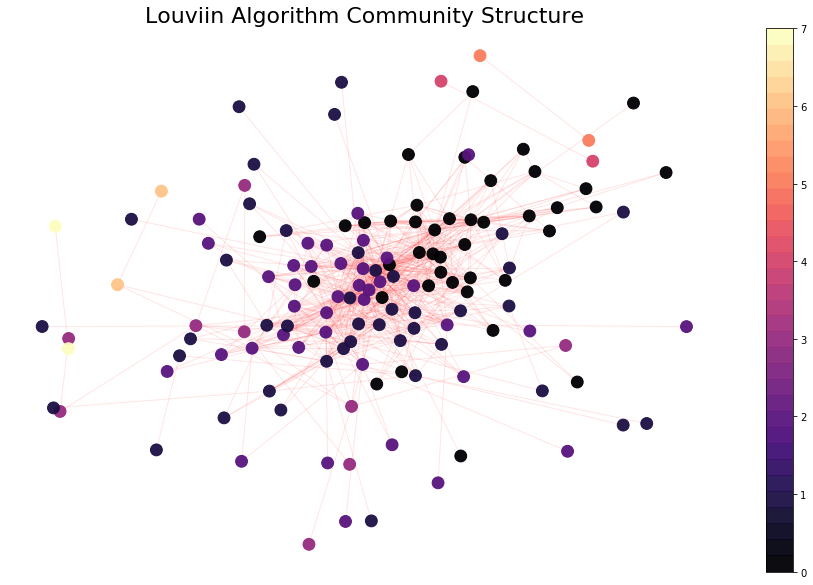

In [15]:
import community
import matplotlib.pyplot as plt
#partition = community.best_partition(com_graph)

values = [partition.get(node) for node in com_graph.nodes()]
values=[partition.get(node) for node in com_graph.nodes()]
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Louviin Algorithm Community Structure"
pos = nx.spring_layout(com_graph, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(com_graph, pos, node_size=140, label=True, cmap=plt.get_cmap('magma', len(com_graph.nodes())/4),node_color=values, alpha=0.95)
edges_plot=nx.draw_networkx_edges(com_graph, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

In [16]:
community.modularity(partition, com_graph)

0.30737187499999985

In [17]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [18]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (mod_texts[word])
        current=cluster
    else:
        print (mod_texts[word])

--------------cluster 0------------ 
 
More context Japanese Slack conversation thing that I said you where we can take yeah so we can add those site that spells along with we data so it can be fine due on that as well along with our previous centric vendors.
I asuming in that this article has some six or seven tax ether if something is as even the the article or six or seven tags it do a you know to sentence code based between the category rock and all the seven talks and take top one and use that as label for this.
Go ahead five tuning we we domain to do Dubai comparison is it we already have the port five little deep like a minute as I said to five you again on S d s have just load that modified tune.
Yeah okay so in theory you are saying that I mean if you go by the flow we can still for to miss out on the first initial ones we will be do we still be context deadly next only go to work three seconds.
This will like be note from the so so it does not show the the entire graphs user 

In [19]:
com_graph.number_of_edges()

800

In [20]:
tg.number_of_edges()

39903

# Redefine the resulatant communities 

In [22]:
clusters = []
temp = []
prev_com = 0
for index,(word,cluster) in enumerate(partition):
    if prev_com==cluster:
        temp.append(word)
        #print (temp)
        if index==len(partition)-1:
            clusters.append(temp)
    else:
        clusters.append(temp)
        temp = []
        prev_com = cluster
        temp.append(word)

In [228]:
timerange = []
temp = []
for index, cluster in enumerate(clusters):
    temp= []
    for sent in cluster:
        temp2 = [(sentence,start_time,user) for sentence,start_time,user in segment_contents.values() if mod_texts[sent] in sentence]
        if len(temp2)!=0:
            temp.append(temp2[0])
    if len(temp)!=0:
        temp = sorted(temp,key=lambda kv: kv[1])
        timerange.append(temp)
    else:
        print (cluster)

In [229]:
timerange

[[('So like right now I think it is building the real because specially pasword word was it got expired it so I started with being process again. So like we will have a build develop meanwhile email level just on the one s case I see we see okay and you and this one network to work related in the call issue like when I with them and I one we trigger into to call so I will test that like we produce it. So what are I was I tried with video like a loan network configuration, but when it happened. I like find out how it happened because the whenever is not network what we now have yeah again, I am not planning on the it. Yes, we call like Google or our handshake end endpoint and like we based on that we see if we get tune that these said that we have it domain, but that also seems to be creating some to just sit there. What is happening there. So what is the check can for the data. I will just check.',
   datetime.datetime(2019, 9, 17, 6, 58, 50),
   'b4a57b25de68446cac990f856d3fe4d5'),
  

In [230]:
timerange_detailed = []
temp = []
flag = False
pims = {}
index_pim = 0
index_segment = 0
for index,com in enumerate(timerange):
    temp = []
    flag = False
    #print ("-----community-----", index)
    for (index1,(sent1,time1,user1)), (index2,(sent2,time2,user2)) in zip(enumerate(com[0:]),enumerate(com[1:])):
        if sent1!=sent2:
            #print (time1, time2, (time2-time1).seconds)
            if ((time2-time1).seconds<=120):
                if not flag:
                    pims[index_pim] = {'segment'+str(index_segment):[sent1,time1,user1]}
                    index_segment+=1
                    temp.append((sent1,time1,user1))
                #else:
                    #print ('removing',time1, time2)
                    #temp.pop()
                pims[index_pim]['segment'+str(index_segment)] = [sent2,time2,user2]
                index_segment+=1
                temp.append((sent2,time2,user2))
                flag=True
            else:
                #print (time2, time1)
                if flag==True:
                    index_pim+=1
                    index_segment=0
                flag=False
    if flag==True:
        index_pim+=1
        index_segment=0
    #print ("-----timeRange-----\n", [j for i,j,k in temp])
    timerange_detailed.append(temp)            

## Redefing the resultant communities using different approach (NA)

In [ ]:
timerange = []
temp = []
for index, cluster in enumerate(clusters):
    temp= []
    for sent in cluster:
        temp2 = [(sentence,start_time,user, [index]) for sentence,start_time,user in segment_contents.values() if mod_texts[sent] in sentence]
        if len(temp2)!=0:
            temp.append(temp2[0])
    if len(temp)!=0:
        temp = sorted(temp,key=lambda kv: kv[1])
        timerange.append(temp)
    else:
        print (cluster)

In [ ]:
flattened_timerange = sorted([sent for com in timerange for sent in com], key= lambda kv: kv[1])

In [ ]:
flattened_timerange[29]

In [ ]:
# ft_re = []
# for (index1,sent1), (index2, sent2) in zip(enumerate(flattened_timerange),enumerate(flattened_timerange)):
#     if  sent1[1]==sent2[1]:
#         if len(ft_re)!=0 and ft_re[-1][1] == sent1[1]:
#             temp = []
#             temp.extend([[ft_re[-1][-1], sent1[-1], sent2[-1]]])
#             print (temp)
#             tot_com = list(set(temp))
#             ft_re.pop()
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#         else:
#             tot_com = list(set([sent1[-1], sent2[-1]]))
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#     else:
#         if ft_re!=[] and ft_re[-1][1] == sent1[1]:
#             tot_com = list(set([ft_re[-1][-1], sent1[-1]]))
#             ft_re.pop()
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#         else:
#             ft_re.append(sent1)
            
ft_re = []
tot_com = []
flag=False
for index1, sent1 in enumerate(flattened_timerange):
    if flag==True:
        if index1!=j:
            continue
        else:
            flag=False
    if flag==False:
        for index2, sent2 in enumerate(flattened_timerange):
            if index2>index1:
                if sent1[1]==sent2[1]:
                    if flag==False:
                        tot_com.extend([sent1[-1][-1],sent2[-1][-1]])
                        flag=True
                    else:
                        tot_com.extend([sent2[-1][-1]])
                        if index2==(len(flattened_timerange)-1):
                                tot_com = max(set(tot_com), key = tot_com.count) 
                                ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
                else:
                    if flag==True:
                        tot_com = max(set(tot_com), key = tot_com.count)
                        ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
                        j = index2
                    else:
                        ft_re.append(sent1)
                        flag = False
                    tot_com = []
                    break

In [ ]:
ft_re

# Alter communities based on time range and get Keyphrases

In [231]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

keyphrase_text = ""
keyphrases_list = []
keyphrases = []
for index_pim in pims.keys():
    keyphrase_text = ""
    for seg in pims[index_pim]:
        if seg != "keyphrase":
            keyphrase_text += (' ' + pims[index_pim][seg][0])
    gr = GraphRank()
    tp = TextPreprocess()
    utils = GraphUtils()

    original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

    word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

    keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
    pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

In [232]:

yet_to_combine = []
need_to_remove = []
for index1,i in enumerate(pims.keys()):
    for index2,j in enumerate(pims.keys()):
        if index1!=index2:
            if pims[i]['segment0'][1] >= pims[j]['segment0'][1] and pims[i]['segment0'][1] <= pims[j]['segment'+str(len(pims[j].values())-2)][1]:
                if (j,i) not in yet_to_combine and i not in need_to_remove and j not in need_to_remove:
                    yet_to_combine.append((i,j))
                    need_to_remove.append(i)

In [233]:
for i,j in yet_to_combine:
    for k in pims[i]:
        if k!="keyphrase":
            if pims[i][k] not in pims[j].values():
                pims[j]['segment'+str(len(pims[j].values())-1)] = pims[i][k]
                #print (pims[i][k])
                continue
        else:
            extra_keyphrase = list(set(pims[i]['keyphrase'] + pims[j]['keyphrase']))
            pims[j]['keyphrase']=extra_keyphrase

In [234]:
for i in need_to_remove:
    pims.pop(i)

In [235]:
# meeting start time.
m_time = formatTime("2019-09-17T06:57:00Z", True)
for i in pims.keys():
    print ("\n\n\nPIMs ", i)
    print ("\n\nDiscussion:\n\n ")
    for seg in pims[i]:
        if seg!="keyphrase":
            print ("Minutes from the start of the meeting: ", pims[i][seg][1] - m_time , "\n")
            print (pims[i][seg][1], " ", pims[i][seg][0],"\n")
            #print (pims[i][seg][0])
    print ("Keyphrases:\n\n ", pims[i]['keyphrase'])




PIMs  1


Discussion:

 
Minutes from the start of the meeting:  0:03:20 

2019-09-17 07:00:20   And other than that like anything we have like in anything that which might be missing. 

Minutes from the start of the meeting:  0:04:13 

2019-09-17 07:01:13   Even the Web has some work to do maybe what we can do tomorrow so i. 

Minutes from the start of the meeting:  0:04:30 

2019-09-17 07:01:30   Youll mute to that so I as soon as we finish like this I was to see alright and like I guess I was going to like the have a meeting good like front end meeting. So like we will we are going to discuss about this in that. 

Minutes from the start of the meeting:  0:04:00 

2019-09-17 07:01:00   Like started to like restart her like we had the end interface. So like we have to start like actually implementing it right because that is provider the prism is then we can like change on this right. 

Minutes from the start of the meeting:  0:05:35 

2019-09-17 07:02:35   Maybe we can do it tomor

## Testing LDA

In [ ]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in new_text]
#doc_clean = [clean(new_text[1]).split()]

In [ ]:
doc_clean

In [ ]:
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [ ]:
print(ldamodel.print_topics())

## Testing keyphrase for the timerange (NA)

In [ ]:
pims = {
	"0": {
		"segment0": ["Like my per month to date most likely as we excuse into which we can that be better more consistent but General aw strategy what they say is have one Lambda the internet coming HTML segment notify is attached a general hook for the data uploaded the Lambda function who associate to the S3 bucket and have that pan out all other language like be a dispatcher. Yeah, thats.", "2019-06-28T06:16:58Z", "2982d23c-1e59-476d-88c8-a42376324142", "ebe8604a02c84952bb7ea9dfccd6c1df"]
	},
	"1": {
		"segment0": ["From by will sync up offline first trusting watertight preview will move manually create a bucket in staging environment and try to use it for testing but what I am expecting is not be a big change. What we what we can do is we can we can remove that CD and table itself from the database because the student table and other other things are actually only used for you know, this sets these things so we give you can remove them. So we will now will have a less overhead even in the future. So because after this change we are we are never going to use the stimuli. and.", "2019-06-28T06:11:11Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "0ef8d453e7bb41d3bd11153827df076a"]
	},
	"2": {
		"segment0": [
			["All right create an issue. Well track it should be a small thing even in the back end to handle. Yeah, I will see if I can look into it today."], "2019-06-28T05:35:58Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "f2d6bb774d5f4649b2e4f15bf07052ad"
		],
		"segment1": [
			["Nothing was done. Headmistress, I would wear black in the public Channel. We need to prompt Channel Minds. Also, I will check with Rashon thundergun. It was another."], "2019-06-28T05:39:19Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "418c719a0f5e4888b242df011e818aa3"
		],
		"segment2": [
			["And updated methods for that which I take do too. Okay. Yeah, I will look into that."], "2019-06-28T05:39:35Z", "d65899ed-e47e-4611-8c2c-59b154ff6a3f", "136b9ea1ccaf461facc5e7953a520ff6"
		]
	},
	"3": {
		"segment0": [
			["Its similar than better to go with S3. If GitHub is not giving you just artifact reading scope or something which release artifact reading Scopes even then it can be weird because if we keep tagging or create a good stuff that are not Jesus files are also generated. We need to prevent them from able to downloading do not also even if they do not we have to protect the code right should not be vulnerability this this take that what is the effort to from Reading from your front door if Jacob does give you anything fixed capacity?. ."], "2019-06-28T05:46:56Z", "2982d23c-1e59-476d-88c8-a42376324142", "8c4e8716db754f82b1ed36c449fa15a3"
		],
		"segment1": [
			["Another markers with calibration issue. I will also take a look on the back end. I know that we have to trim the edges to remove the flashin but I do think that if someone puts a empty space between two sentences that can cause an issue. I will just go check. Why is that occurring and see if it is something easy to pick up and then the back end also?."], "2019-06-28T05:50:04Z", "2982d23c-1e59-476d-88c8-a42376324142", "3c74a71652394d65abed891a412c008d"
		]
	},
	"4": {
		"segment0": [
			["You things on whether can we go eat on to Lambda or whether she should whether it should be based on the current key phrase. Maybe we will just take it off way, or I will talk to Sasha Hank and understand and get those details. We did have some plans to move it along."], "2019-06-28T05:57:22Z", "92b4588f-74cc-42f0-bf6d-eec0b6198ade", "6b474e34b42a4514b7689a378bc47c66"
		],
		"segment1": [
			["Between making calls on Tims and waiting on the one that comes last. Yeah that still happen because we will have to wait on the consensus of the what we need to do again is somewhat more on the cause they custom server is not doing anything and then it out into my you are still paying for the execution of the Pim. Lambda looks right at is one thing you can reduce but also the fact that we are right now waiting on Transit segment to complete I think within being the change we will need to wait on transcript second segment to be analyzed. Those are the events that trigger are some regeneration. So if it makes it and because that tramp is segment competed in already in the event of are acting on making this switch to the next most relevant is not a big problem. So it is more even driven so we do not need to wait on okay. Okay. Yeah, and then on the."], "2019-06-28T06:00:48Z", "2982d23c-1e59-476d-88c8-a42376324142", "f5c2855a681c40c8b5a77a85c5c0fd6d"
		],
		"segment2": [
			["Loved it. Thats fine. For now. I think you do. I think once you go to production, we need to figure out a way eventually to not lock sensitive information like transcript segment data Etc. And that will cause some you know issues still doing that. So but ceasing to your fine, too. Yeah."], "2019-06-28T06:02:50Z", "2982d23c-1e59-476d-88c8-a42376324142", "f56de51245ce4fa69c6628e5dc066369"
		],
		"segment3": [
			["Make a contained environment. You cannot specify the requirements separately and then all the executable file separately so that you can put the files as layers. I was just trying to do that, but I could not find it in the process of doing a trigger. If so, why?."], "2019-06-28T06:03:45Z", "f6b27e4a-ad4f-42b3-ac18-e09ec396685b", "4fddeb333fe745cdac8ee41d5785d0ba"
		],
		"segment4": [
			["I think when cat had reduced it to Fighters, I think Sicilian fighter he moved to by Torchlight and side by and all the mines and this one. So overall I think the thing got to do but we ended up using layers so we might be can end up adding both the layers for five dots by touch light and maybe scifi known by all the psychic number like it has layers and learning anything network accessible routes like that, but if sound 50mb."], "2019-06-28T06:06:36Z", "2982d23c-1e59-476d-88c8-a42376324142", "cc29605c0446480f8ace87c4d6593d8a"
		],
		"segment5": [
			["So currently was just working on the refactoring of bug book printing that is done basically it is in like the record reviews review comments have to just address it so apart from the doe those comments look straight forward or should not be a bigger big thing is basically so the other part is the pims part the the pins which are not seen in the mix does not constitute the last last few segments the meeting right? So that issue if started working on it like probably a bit Monday should be able to send the send it for review that code. Okay. Yeah that I maybe I will have to ask like more technical things. I will have to ask like if there is anything which I am missing missing I will call you again."], "2019-06-28T06:08:07Z", "6e8408ce-1072-4209-9e82-945701c7b86c", "439f3d6209184e19a7de54c59a8c4533"
		],
		"segment6": [
			["Make a contained environment. You cannot specify the requirements separately and then all the executable file separately so that you can put the files as layers. I was just trying to do that, but I could not find it in the process of doing a trigger. If so, why?."], "2019-06-28T06:03:45Z", "f6b27e4a-ad4f-42b3-ac18-e09ec396685b", "4fddeb333fe745cdac8ee41d5785d0ba"
		]
	},
	"5": {
		"segment0": ["But we we have done it. We have done it only from our office and I am not confused coming from that one will because people in the calls are like variables XnumberX  scholar two persons called Waterloo. We visited a real scenario kind of thing according a minimum XnumberX people per call because we just need to load test it and because it is normal generous mood worth but under the cave under the load, how does how its behaving that we need to check? Yeah.", "2019-06-28T06:21:56Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "b573665bbeae49bdb26020751122dfc1"]
	}
}

In [ ]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

keyphrase_text = ""
keyphrases_list = []
keyphrases = []
for index_pim in pims.keys():
    keyphrase_text = ""
    for seg in pims[index_pim]:
        if seg != "keyphrase":
            keyphrase_text += (' ' + ''.join([i for i in pims[index_pim][seg][0]]))
            print (keyphrase_text)
    gr = GraphRank()
    tp = TextPreprocess()
    utils = GraphUtils()

    original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

    word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

    keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
    pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

In [ ]:
pims

## keyphrases comparision with word2vec (NA)

In [ ]:
with open("../data/meetings_slack_embeddings.pkl","rb") as f:
    emb = pickle.load(f)

In [ ]:
nodea = 'sql'
nodea_fv = emb[nodea]
closest_match =[]
for nodeb in emb.keys():
    if nodeb!=nodea:
        diff = 1 - cosine(emb[nodeb], nodea_fv)
        closest_match.append((nodeb, diff))
closest_match_sorted = sorted(closest_match, key= lambda kv:kv[1], reverse=True)

In [ ]:
closest_match_sorted[:5]

In [ ]:
import pandas

df = pandas.read_csv('../data/query_resultsync2.csv', index_col=False, header=0);

import json
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp
data= {}

segment_contents = {}
texts = ''

for index,segment in enumerate(df['value'].tolist()):
    data = json.loads(segment)
    if "google" not in data['transcriber'] and data['originalText']!='':
    #if "google" not in data['transcriber']:
        texts+= (' ' + data['originalText'])
        segment_contents[index]= [' '.join(tp.preprocess(data['originalText'], stop_words=False, remove_punct=False)),formatTime(data['startTime'], True), data['spokenBy']]
        

In [ ]:
texts

In [ ]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

gr = GraphRank()
tp = TextPreprocess()
utils = GraphUtils()

original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

#keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
#pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

In [ ]:
com_graph = GraphRank()
nodes_list = []
for indexa, nodea in enumerate(list(word_graph.nodes())):
    for indexb, nodeb in enumerate(list(word_graph.nodes())):
        if indexb>indexa:
            if nodea not in emb.keys() or nodeb not in emb.keys():
                #nodes_list.append((nodea,nodeb,0.5))            
                continue
            nodes_list.append((nodea,nodeb,cosine(emb[nodea],emb[nodeb])))
#print (*nodes_list, sep="\n")
nodes_list_sorted = sorted(nodes_list, key=lambda kv: kv[2], reverse=True)

nodes_list = nodes_list_sorted[:math.ceil(len(nodes_list_sorted)*0.05)+1]

com2_graph = nx.Graph()
for nodea,nodeb, weight in nodes_list:
    com2_graph.add_edge(nodea,nodeb)

partition = community.best_partition(com2_graph)

In [ ]:
community.modularity(partition, com2_graph)

In [ ]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [ ]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (word)
        current=cluster
    else:
        print (word)

## testing ground

In [ ]:
text_1 = "We have now created a simple network with Terraform on GCP. You can do a lot more with terraform such as setting up compute instances, firewall rules and much more. I thought this was necessary for the kinds of apps I was working on. And with that in mind, I tried many approaches and frameworks for implementing the same pattern: Single-page applications (SPA). The next thing we shall do is get the necessary credentials from GCP. Go to the GCP console menu and select APIs & Services then Credentials. Now click the Create Credentials button and choose Service Account Key. On the next screen choose Compute Engine default service account and JSON then click Create. This will download a json file to your computer, move this file to the folder where we shall write our terraform code. This file contains sensitive information so do not store it in a public repository or make it public."
text_1 = [sent for sent in text_1.split('. ')]
text_2 = "properly applied HR strategies ensure that  strategic recruiting and retention processes are created that fit the organization.There's a clear need for increased visibility to drastically improve sales. But in order to get more visibility, businesses have to spend more money. When that well runs dry, what are you supposed to do?.  strategically applying smart HR insights into different areas of the business tends to improve employee engagement throughout the company. However, identifying the right strategies to market your business is often likened to rocket science.  Some businesses have been built solely on the backs of social media. How do you get your message to the right audience and do it effectively? How do you boost visibility and increase sales while sustaining a profit with a converting offer? Today, with so much vying for our attention from social media, to search engine optimization, blogging and pay-per-click advertising, it's easy to see why most are ready to pull their hair out.The truth is that what got you to this point in business is likely not going to get you to the next level. If you're feeling stuck, join the fray. Most entrepreneurs are so busy working 'in' their businesses that they fail to work 'on' their businesses. As a result of dealing with the day-to-day operations of a company that includes customer hand-holding, supply-chain demands and more, we often neglect to wield the right marketing strategies that will help fuel our business's growth."
text_2 = [sent for sent in text_2.split('. ')]
print(len(text_1),len(text_2))

In [ ]:
c_fv = getBERTFeatures(model1,"", attn_head_idx = -1)
c_fv2 = getBERTFeatures(model1, "", attn_head_idx = -1)
#getSentMatchScore_wfeature(c_text, c_text, c_fv, c_fv2, nsp_dampening_factor = 0.7)
1-cosine(c_fv,c_fv2)

In [ ]:
label = {}
for x in range(10):
    label[x]="in-domain" 
for x in range(10,20):
    label[x]="out-of-domain" 


In [ ]:
label

In [ ]:
for index1, text1 in enumerate(text_1+(text_2)):
    for index2, text2 in enumerate(text_1+(text_2)):
        if index2>index1:
            text1_fv = getBERTFeatures(model1,text1, attn_head_idx = -1)
            text2_fv = getBERTFeatures(model1,text2, attn_head_idx = -1)
            cosine_similarity = 1 - cosine(text1_fv, text2_fv)
            metric_similarity = getSentMatchScore_wfeature(text1, text2, text1_fv, text2_fv, nsp_dampening_factor = 0.7)
            
            print (label[index1] + "  and   " + label[index2] + "   scores: " )
            print ("cosine similarity: " + str(cosine_similarity))
            print ("metric similarity: " + str(metric_similarity))
            print ("\n\n")

In [ ]:
## subtopics

topic_1 = "We have now created a simple network with Terraform on GCP. You can do a lot more with terraform such as setting up compute instances, firewall rules and much more. The next thing we shall do is get the necessary credentials from GCP. Go to the GCP console menu and select APIs & Services then Credentials. Now click the Create Credentials button and choose Service Account Key. On the next screen choose Compute Engine default service account and JSON then click Create. This will download a json file to your computer, move this file to the folder where we shall write our terraform code. This file contains sensitive information so do not store it in a public repository or make it public."
topic_1 = [sent for sent in topic_1.split('. ') if sent!=""]
topic_2 = "I thought this was necessary for the kinds of apps I was working on. And with that in mind, I tried many approaches and frameworks for implementing the same pattern: Single-page applications. If you work in the JavaScript ecosystem, you are most likely aware of how difficult it is to manage dependencies.When one of your core libraries releases a major version, it is time to start thinking about upgrading. Imagine that a library named X has a peer dependency on React and you are migrating your application to React. Maintaining an application with a large codebase requires a lot of discipline and having your dependencies up to date should be a top priority for your team and organization. "
topic_2 = [sent for sent in topic_2.split('. ') if sent!=""]
print(len(topic_1),len(topic_2))

In [ ]:
label2 = {}
for x in range(8):
    label2[x]="topic_1" 
for x in range(8,14):
    label2[x]="topic_2" 


In [ ]:
for index1, text1 in enumerate(topic_1+(topic_2)):
    for index2, text2 in enumerate(topic_1+(topic_2)):
        if index2>index1:
            text1_fv = getBERTFeatures(model1,text1, attn_head_idx = -1)
            text2_fv = getBERTFeatures(model1,text2, attn_head_idx = -1)
            cosine_similarity = 1 - cosine(text1_fv, text2_fv)
            metric_similarity = getSentMatchScore_wfeature(text1, text2, text1_fv, text2_fv, nsp_dampening_factor = 0.7)
            
            print (label2[index1] + "  and   " + label2[index2] + "   scores: " )
            print ("cosine similarity: " + str(cosine_similarity))
            print ("metric similarity: " + str(metric_similarity))
            print ("\n\n")

In [ ]:
test = {
    "0": {
        "segment0": [
            [
                "Yes cannot think still senior you sure that is coming."
            ],
            "2019-07-24T15:59:40Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "0399616ea53f4fa7ad42970ed8d78db4"
        ],
        "segment1": [
            [
                "Give hope I channel Okay right okay so topic what I thought we will do is I just wanted to have like a bunch of discussions. Firstly what is the test how we is working on that, but also I thought when use is just go back and forth in accommodation format. There will have some discussions about you ether platform technology choices. What we do where we can improve you know what are some of the problems challenges that we faced coming up to this point cycle. You know how are we doing compared to industry standards or what folks are talking about industry and all that so I just wanted to can keep it interactive. They would not keep talking about it month like for so let me start with maybe just at high level right so architecture choices. You know, I know we started off from literally from brand sheet of paper. You know they we said we built this using a variety of different technologies can gone that traditionally Commerce more that three based for example and Java based my chris."
            ],
            "2019-07-24T16:00:07Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "34c5024cdf914228b8501e4585098e4f"
        ],
        "segment2": [
            [
                "And and more more tell Amazon for example, we how went the part of you know either not just going a tomorrow at the same time not going with a full services architecture and also going as well dont core main choice with back. So can you walk me through that process sure so before diving into the."
            ],
            "2019-07-24T16:02:01Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "c0a1f97f95b64c8aba82813e99489eae"
        ],
        "segment3": [
            [
                "Let is talk about the decision around that they we wanted to go with model this services or why we went to something in green. Yes, it good point to start because that master that the language that you choose hmmm from you know from I mean most of this is come from experiences both working at living to where we working on a model and moving to Groupon, which was a heavy presented company a with a huge model in between so some of the learning that we took from that was before getting into model the micro services. There is something that I be very was do not come a framework frameworks like Ruby or something that is too allows some invoices from kind of practices upon the developer and sort of expects the about the right code such that will only work well written in that order and to word away from the same words, you know specific in a workings and things will kind of make you words from the community around view also right. So especially when we work then like one of model and rails backend group on one of the biggest problems are things like handling database connections across different regions. You know using the appropriate data connection database connection or you only your master et cetera and you have to do a lot of to get that in where we go in have had to had chosen the right form of abstraction and design patterns that are put in place and will allow us to easily move with logic or handle much well the second thing was at least some other framework."
            ],
            "2019-07-24T16:02:36Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "0360786073c64971864925d05327ff36"
        ],
        "segment4": [
            [
                "And and more more tell Amazon for example, we how went the part of you know either not just going a tomorrow at the same time not going with a full services architecture and also going as well dont core main choice with back. So can you walk me through that process sure so before diving into the."
            ],
            "2019-07-24T16:02:01Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "c0a1f97f95b64c8aba82813e99489eae"
        ]
    },
    "3": {
        "segment0": [
            [
                "Is very important for us to handy so that allows us to so you do not want to focus on things like collection things like that, especially when you are small you want to focus on you know and figure how to make come currency like like by myself for example or do be a blue and logs just incredibly hard to work make it the sustainable small advocate application. There is just a lot of extra work that we need to do this to get it working well so I show them out at least for the core platform is mainly our call platform actually, but for us just to go with items because the so comfortable with it and the variety of the same most of it are implemented. So so with respect to that the problem with Java the one of the two main part Java of was types so when you had to great clases and yet to create interfaces. We have to say this clas implemented interface and make sure that you try to not try to get in exactly the dependency place and worry about those things and unless the clas does not provide implement interface even though it has all the messages. It does not work out definitely at that point time was somewhat shaky if the Java had been introduced because not as efficient as go she was or not easy to manage the way go had done with respect to go things in the way managers in admin manner scale was interesting because it is a functional program language for the problem was there were just not easy for developers to get onboard with and the bigger problem was that it had a functional."
            ],
            "2019-07-24T16:42:48Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "485300f6f5df4b02bc1e2ed86c3db17b"
        ],
        "segment1": [
            [
                "Do it, but also allow you to do manner which I will call it at the bad thing but it is just that there was no proper guidelines on how you use specific based on what choices. So most of the experience support were like is just incredibly hard to do reviews developers would constantly argue us, which is the right or the most way to write code and this is focused on those just figure on how what is a good design how the this code scale that and so we sort of makes call know now let us just put that aside look at closure. I ideally like that a lot but again I because it to the list of the foundation of the language is very small. There is not a lot of things that learn about the language to go work. Yeah, but that because also that it is list most people uncomfortable, especially because when we started it. We need people with media processing background. These will go at work especially on lower level systems and plus plus with handling network related itself are heavily comfortable of as a language and to train them do not just learn like how to write high level software was one concern that Wouldve happen regardless of what language. We choose but on top of that piece then my whole different paradigm. I am of writing go reading code would just be another concern at that point right it also had good teams in so also nice and the way the languages was defined and maintained by the core team was very nice open changes they are are now going to do introduce changes are already stable you can use one want which is a big bonus because we get to follow the and also."
            ],
            "2019-07-24T16:44:48Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "6f4b21e7a4cd429ea7ebc15e0466cfdd"
        ]
    },
    "4": {
        "segment0": [
            [
                "But those do not this Thursday they all implement these instances because then you try to between packages which is not great. I just wanted to use that package termination whether or not I take it to it in this system or not is a different. I just wanted to use that isolated manner and if it stop and software. So that ability was really nice which go really put thought out on and that allows get a lot of code in that manner that was very important at least for me there is very important and definitely simplicity that android division management to move it in."
            ],
            "2019-07-24T16:50:48Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "4716393165334ea1babd6349af31719c"
        ],
        "segment1": [
            [
                "And there was a lot of opinion views and how you should be writing good go there were things like go format VR respect to how you I mean this still are but it is not that back right like with respect to format my team style guide that you dont discuss the team is already opinion. Lot of things are pretty good things like in there are some inheritance which is when you are not a experience program or integrating them and understanding them understand things like you know solid principles etc takes a lot of time and takes a lot of experience for them to understand you know interface segments and cost principal etc. Then you should use a channel clas and you should do the parent clas cetera and that sometimes is not easily available. The clarify using composition over intelligence is very useful and the way goal does to is pretty nice that is very interesting the old font the language and does not have more than keywords. So this is very small language at its score. So there is useful and they also goes on explicit code right? So there were not things like lot of use of reflection at least every everywhere like would use an base programming like one would add in Java like frame. Basically next spring or where you use the like you use dependency injection to solve the dependency version and most of it was this random time dependency and spring is basically branded independently injection framework. So a lot of times I have seen there is a lot of complexity. I just how systems away and most of the time in go you just start provider it in the main you do not have to do a lot of the."
            ],
            "2019-07-24T16:51:34Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "24c32599e13b4ec299fc70c36276eb72"
        ],
        "segment2": [
            [
                "Most of the time every balance if we good going to write good more code that is but that is of the language. There is saying that do not use AI like banks injection as much responsive that is not two. So simplicity was very important like how the more simple code the more understanding to more reusable right and the concept using one defined interfaces with least number of methods in it was also good of this. So that you increase a usability of the code all is three times like interfaces revenue this remote part which we do now use a lot of effect we do now use a lot of to but when started we to so that is not like the biggest thing but was definitely going to yes not having to do corpus collection management not having to to yeah, the Java selection speed staging path and still less to this day never had a problem with asuming it I we are all the changes. So how quickly you get integrate through now definitely one thing I miss about what things like with the process with closure was an development you try to think of process you come up with the thought process you try to implement it just dynamically see if it works and you written the core is copied it and done so that kind of provided in the evaluation strategy and think the process solving problem is not still something that go application still not to so that is something I do definitely miss and alert seen that."
            ],
            "2019-07-24T16:53:34Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "e13950b5882f484e9f89e72d13a432ab"
        ]
    },
    "5": {
        "segment0": [
            [
                "I would want to negotiate it or would be for a lot of work like exact some some load where data a lot of places they do not need to info types around things or want force integrate. Now with the closure a really good content gradual typing. So it is essentially you can create it is still still of G everything just boils into a tight internally when it jump compliance by code but at the higher level. It is a dynamic program, you will language to the end user right? So when they they dont define types to everything so getting errors address is not so what they do is we can define like metadata on functions like crackers saying that this been engineers should be of this between this time I automate make errors is and top that background words. So that is pretty interesting but definitely would you flows for lot of work where I just straightforward code as data to lot of lead on of code possible and ID user doing data the team things on this like that maybe writing scheduled lot of complex code that you would not want to use like low level. I think that is definitely one thing and so that is pretty interesting like."
            ],
            "2019-07-24T16:55:38Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "1ad3240eb67d4a0ea34f871c5824379c"
        ],
        "segment1": [
            [
                "Failures cetera or you can use the messaging system which lacks and support on domain but definitely moving down even system system makes more sense than just going to something like right road above its serial I am not really opinionated that I am not really that on comments because at our because we do not have a lot of moving mobile parts in the part system. So definitely saving compute time by creating my of for utilization will not give us any benefit at this point or which will be to the point where users use any benefit the and is can benefit so it is hard to comment on whether we should have used in the beginning or in the beginning, but what we do some days we are thing about using for for concessions to of data metadata data like models all of that stuff like you know marketing heavy data like case and responses maybe total for Pierre stuff that may be something that we can explore but definitely for process communication will be core platform. It is not really something we looking into the other a problem with part of us was it least a lot of core generation. It is a good thing in a bad thing the good thing with systems is you just define back. Once generate clients every everywhere that everyone wants to use but the problem with I think things like there is a lot of more coordinated generated with respect to structures define just for that they can be receive."
            ],
            "2019-07-24T17:00:52Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "25b34b08c838427c90e38deec43d321d"
        ]
    },
    "7": {
        "segment0": [
            [
                "Clarify before that we are not truly a model in the traditional sense as Google as or Facebook case because if you look at it back all of base everything is almost all open source integrations, but everything that is go to their system is in one single april and definitely as we mentioned they have have taken a lot of the done lot of special teams completely focused on improving the productivity developers developers working on main so that is definitely becomes a road at some features for a small complaint like us that we would not want to spend so much time on efforts on those things hooks on the post product now in that sense what so let us try to address with one by one. So what we do we do not have a traditional transfer not all every based in the same. So what we do is we separate the by that concern like by the team points are using it or core group of grouping and the high working up who users it and for what corpus so the front end has a own report but the front end related stuff which is for the mid use case I will not save for everything that we will eventually put some share how are the minor push it elsewhere, but we see that enough work that can use across up use cases for the core platform which completely in goal line at least ninety two right nine percent of it is in goal line that and platform related a P are all in a moral because the entire platform team, which is currently than five people need to maintain in all of that stuff. So if that is one of the use case, this is very essential to our company which is the AI engine right the so that we need to have mentioned respective access to who."
            ],
            "2019-07-24T16:11:58Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "fae2ecb9d0814afe95a84ad956988bb4"
        ],
        "segment1": [
            [
                "So access that code base and this will look at base so that becomes its own which is completely python icon as that is we thing most AI developers developers are comfortable with. So we chose a language based on the use case and choose to four days on the moment code to the so in that sense a lot of problems with Google and favor at with the structure management everything comes into problem when you are having to put code based of different management the same and that least a lot of hierarchy depth of going into code and looking at that things that brings a lot of complexity which we try to avoid by doing it this way and fourteen people that and of which like no team is there then five know would intent so right now this works well for us the second thing is to respect to managing that is definitely good point. So at least the thing that gets deployed most frequently for us is a platform and the front end code is now the front end goal base right now it is not totally more more or that we have separate approvals for IOs and separate the web, but we will a converge by use case like the mid case we have the first one into a own and share with shared the reach. They can use but in terms of their own bill everything they only choose to build the files that they need. They will not pas so the entire holder structure to read all the files they need to come. It is like they go from the index and they try to go to the graph and directory and."
            ],
            "2019-07-24T16:13:58Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "566413246226417c891f0be99701acf9"
        ],
        "segment2": [
            [
                "Go through the three and they try to resolve up it. So right now it is pretty fast at least from the front end point it is not go. Now this is where for the platforms has been a pretty good thing with one of the good productions go with going with the language here was good because go perspective of the size of the code base the time does not generally beyond five seconds for us and we have seen case studies and experience supports by different companies around their experiences writing large managing large base of code goal and how has been placing parts to them so for and concern but definitely something that will come into to column CEO steps right how do you test everything once you make change or you back to something that is is you know that has like permissions across different it is the code based or that is something we need to continue to work on, but even then one of the thing is in our systems based on the deployment that we have so we deploy the a or the slack or we deploy so that socket a gateway or the lambda functions. Whenever you be configure as such way when you trigger a push to one of those code basis. It basically runs a simple from the main main file for that specific base and try see that files or not at least that right now seems to be working but definitely and because lot of the code."
            ],
            "2019-07-24T16:15:58Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "92c33f93e4cf46a498dcbaedb2e5d02c"
        ],
        "segment3": [
            [
                "Shared I sort of on to almost everything but because we use go again the time everything seems to pretty pas so the test cases they are all run family so they do work but definitely if you look at in terms of size the code base there are two of big concerns with smaller post right one is size of the code base and growing test cases and time it takes so execute so many current across the code base. So five code is definitely concerned especially with the platform because this platform, but at least because platform. Keep deploying for the are more three countries in the who and deploying machine models frequently, then change. So that is a different concern there, but from platform benefits. There is a lot more code involved. So that is something that Google and Facebook have worked extensively on coming coming with a virtual file systems forget where they download specific parts of the core basis based on main stages are the teams who are on specific parts have that kind of sophistication right now and and and and I imagine by the time that we grow so big do such big team we probably ended up breaking the more we go down to services and asigning team because it is not generally at least a company of our sites to be with managing the tools in that question. Now definitely one can say that we can adopt tools that Google or Facebook built and that is something to us, but they not use enough ID to be able to commit to something at that skill this point I have looked at things like get file system by microsoft it only use works windows those."
            ],
            "2019-07-24T16:17:58Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "d1dc92db4bc04ebfa9a2f5dfd70aefc4"
        ],
        "segment4": [
            [
                "So and Google will also have certain time, but different of usage and terms of community support. So we will see where it goes but definitely gives the way we written our more core for that platform. We can easily break down like meeting service or transcription service is done. So on and deployment procedure and once we have a team. That is large enough to maintain that specific for the or the code goes too big for the go platform work on so that is how long break at least that is the thought process right now."
            ],
            "2019-07-24T16:19:58Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "14cebf347c434f3db6e126c5bcb706a1"
        ]
    },
    "10": {
        "segment0": [
            [
                "Language the way you handle database and like they sort of introduce all of the conferences that our database management into the language which is very incredibly useful like transactions in the language and instead using new Texas and and ability to and like persistent data fixes is very nice basically whenever muted is you will get a new Richard back just someone more like, but essentially was not and how it does make its own three et, I was pretty interesting and was thought out and it would definitely I would go back and I would not go back, but basically if the team grows and we able to split into smaller teams where we start a microphone services if I had to use under another language. I would definitely choose slow here as all of language because it was easy because you never muted code right in our muted by not to do it as as much possible mode which means there automatically reached leads to like code and code and you to get a history of how thing has seen to what time and all of this. So which is very incredibly useful like and sort of symptoms terms of how developers that ability so that definitely one choice. I would go for but definitely at that time it is not the direct as first because generally, the average time to get on onboard to be a good project developers around six months. So they months road media processing guys an understanding program language conference with I was one concern. Now go was very interesting in that order because."
            ],
            "2019-07-24T16:46:48Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "46e342ffb73945a0b8bbcdd0a41d9344"
        ],
        "segment1": [
            [
                "The core focus of the program language. It is very similar to see like emergency systems language, but it also has really good standard libraries for C T p for H C D B and our task and I could just go into the library and just look at the chronic and and what has being done by they need position with that. So code pretty high the concerns the other thing was definitely good was a really big role of the how come currency managed and go is very nice based on force paper communicating three its own thesis et cetera, but essentially the way you reason about how systems should interact between how different parts system can interact not to sharing memory your communicating is a very interesting in a good concept. Similarly to essentially very different, but different top using threats not using processes and the community was growing in I had a feeling that the community was kind was going to increase it especially in India on the word which it did there is is a good but to give the attraction that lot of companies had adopted it like Uber that and they are are locally go very vocal about their experience process go to be important, but one of the really good reasons choose go was that ability or that concept around implicit interfaces and since you the defined interfaces, which is very which is very an architecture way right you define interface inside the package you want to operate on and have when you acquiring system. You the inject implementation asociations of implementation."
            ],
            "2019-07-24T16:48:48Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "97ee876792fd4899b24fdca4423060c0"
        ]
    },
    "13": {
        "segment0": [
            [
                "Saying that the fundamentals in how you approach different these right as of concern. So database need to be separated to its own layer. It needs to be separated from the branch layer, which could be sheet we can we did not know because we have enough time to are so many different things that one shot, but if you choose to separate delays independently you could easily stop in our different different or at least progress in know unless but get a successful fashion to update migrate into the you could have a migration part flow to process somewhere right? So that is where we thought the key architecture that was as that has been spoken about for so long was useful in that process where they force use of but not frameworks right. So using the right interface was important for us. So it does not matter what remove it as long it user. The right set of abstractions to how doing so that is the first thing right and and it starts to choosing name model versus Micro service. Now once you have clean architecture in place you do not really need to think about whether guess when come to place there are automatically good design patterns and concerns that automatically get in force by which you can commit code to the team report at least before getting to tomorrow services and later decide whether they orders split them or move them based on deployment concerns or how they are scale. So what are concerns they were we could choose to move them out independently in a slow fashion."
            ],
            "2019-07-24T16:06:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "26696a3db44446bb83f99fa8dbd94c69"
        ],
        "segment1": [
            [
                "Because when we started we were about three people right. So three a first managing services is big problem because we seen that before when also so I think choosing like right design part concerns will definitely put a long way into deciding whether they want to remain in a model or local service. It is a model that is the right word model fine means that entire deployment sort of lies in one process, which it is not so we do separate the contents when is required like the end separated from the backend end the platform go platform some of the deployment deployment concerns like let us socket gateway or something else which requires that own scale concerns or maybe need to be exposed to the outside world, but does not need to track me they are generally they deprived separately this, but they do end up who be hosted in same people. So we follow model architecture see and domain driven design this help defining what bound context the systems interact with and how you go about creating like the this separating deployment or wiring audio system from the core business logical systems containing packages. So that they help us a lot way and we still in a on fashion at least for the platform front is definitely separated and is also a separate so the problem is now lets want to languages before I go to."
            ],
            "2019-07-24T16:08:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "a268ac1f9a774b3ca327ea43122bab65"
        ]
    },
    "14": {
        "segment0": [
            [
                "Layer and then you can in the service layer itself. You can have a multiple concerns one is we want to log certain things right we do not want to last you want to headers back up and log it in a common place. See you but this but when you do and just long you want the log and define sort things like watch service method you it. What are the input that you define how much time did take to perform just operating at the service layer not involving the time to transfer to the network or doing anything like that. So you have a mid very symbol right? So we want to push metrics business metrics or not is not the respect to end points. But this is metrics do you want to do some logging maybe be some so of several that it is where you put it. But you can have some user that a pattern as you want would stay where you pas the data interface how what the methods essentially this service should be doing on the piece of code like a meeting server should be doing and you wrap the same implementation of a logging system of the metrics publishing system and you ask them in words and the most thing would be the core so is that actually does the work. So so that is one level middle based the business or the service later then you back up to perform to think Singapore. Okay now dial dealing with how my system interact with other systems in the company and how it performs. What it needs to the status are the business requirements. Now how now is to now let us worry about how systems communicate with each other right. So then transfer put it layer and work. Now in that that you have to worry about okay, how will I transfer information between two services also."
            ],
            "2019-07-24T16:23:25Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "63f3a7e75044439fb4bc22fd06f54b1d"
        ],
        "segment1": [
            [
                "Company right need worry about Okay how would I create a representation of the clases of languages into a common save format that can be transferred over the wire. Maybe I strong representation or by representation whatever it. We so that other systems can understand into and interest and perform some other of compettion and give back and talk to each so those concerns definitely come up with the transitions we need to worry about what protocol you want to use the time to talk to between services. What is the utilization you want format much wanna is protocol buffer and they want to use R P C or case an whatever it is so you move those up to a layer about and you have interfaces around that right. So one should be easily be able to swap out an implementation with the implementation without having to change the systems the service layer positively layer. The cash systems are any business logically. So you want to when you make it change your goal should be not or your changes down to every part system right if you are touching layer the changes is that you implement should only touch that layer so that you do not have to test every products of that by making a code service is robust right so that is the concern of the transition there. So how you ideally do these of stuff now having now now when we are in the service layer or the controller earlier layer you do do some I related work you do talk to other services you talk to the databases you talked to cash systems."
            ],
            "2019-07-24T16:25:25Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "7513544127fe4fb8a57cf4808d960256"
        ],
        "segment2": [
            [
                "Now how we do that how do you do that because you can have this fund implementation we have the so many database to use right now my sequel or you can even now the problem is if you commit yourself to one database and actually write this queries in one directly in the controller the problem that it very hard to couple of your database level concerns on a code business level in the controller level right. So what one does is move create from interfaces around how your service interact the data database later we create the database active objects just the technical terms that people use so database access to sorry. Let is say for example and leaving with the so entty call meeting some of the common tasks that would expect to do with the would be to get a meeting by identifier to store the meeting object if I give it and two be able will do query meeting days on certain attributes if I need to which again, those interfaces. Sometimes can be very databases certain databases. Sometimes cannot this important for one to think about can I use a light while you store in general, but sometimes you might have to query by certain with different differently in narrow. You might want to have a initial index which table with an index on which is your one in base systems you can just maybe just create an directly understand table itself but that dollar consider the database how you optimized query inside the database should be separated from your service layer. So that is why you can create that kind of way."
            ],
            "2019-07-24T16:27:25Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "1058c8d49d70468babb600d4e25fb928"
        ],
        "segment3": [
            [
                "And you talk to those things through that kind of interface. So can just when you wiring your service or application. We can just initiate a different implementation with call repository pattern. We can see the different implementation may see instead of both move to my sequel data organizations. We concern but once we do that you can create in translation on my sequel repository and and just it to the and of your service. So internally product intel where does not seem because the scope database. So isolate testing by the layers that you want that are concern with it that point of the architecture. So because we do that if right and maintain maintaining you just by layers and you can if you may you change latest a specific specific component and does not format. So you do not have to worry. So in a way you can say the marker for good software is by how many lines of code or how many lines of core added, but more importantly how many clients of code not altering it every i."
            ],
            "2019-07-24T16:29:25Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "9032f6520e014231967dd5f9dfbf1fee"
        ],
        "segment4": [
            [
                "That is say from why understanding is the importance of choosing from the making architecture because we are separating different concerns. Now as I mentioned how different systems need to talk to each other. Now that is that as a problem right. So generate arranged approach people tend to be each new entty its own service just because this thing that is the way it should be, but does not have to be right? So you need to figure out how different parts system can work independently from each other and what system parts need to talk to other parts system right so you try to in your mind right to form abound context. What are the roles and responsibility for a ttle system and you define whether the roles in response and you try to fix it to some extent and if decide whether it needs or does not meet those constraint and decide to break the system down or to create it on create separate system whether constant and have interact between things. So to give an example, list like at least in the ruby, you would have a forward all models right and you put the meeting entty put the transcription entty you put like contextual core object like an entty detail into the same folder essentially and by doing so what is happening is within that photo people do not try to create tight between those entties. This is really the is this one and there. It is easier to paint the relations to things."
            ],
            "2019-07-24T16:30:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "38e098c22ee2468983f3d7021cdfbc0a"
        ],
        "segment5": [
            [
                "So once you do because seems hard to break the system. Now because there there can be sometimes dependency that client is is support, but we just will not be able to figure how to bring this now right? So one thing that is important is figure out okay what entty should be isolated from what we are the entties and what were like higher level entties high deposit that need to talk to lower levels systems there to common an operation. So in my mind I try to think of it as zero one to services where zero means complete we operate on the input. They do not talk to anything else tier one basically auto to one or two loud mobile less. Well will we talked to lower and zero or one different. So so he try to buy different systems based and me from what environments. It is important to move systems around to pay to the bottom case much as possible. So that they are more reusable but sometimes it is not possible. So to give an example, there are far system where in our company that want to build the platform right our core l related services are t zero and they to operate like a zero or at to some extent one service depending talk to some other services, but they should never go beyond that so because we want high the usability of those things. So we try to figure out okay we want a contextual score you want a keyword factor we have maybe transcription engine. We have use service and we have some other services that know other service in the same level should in the same can talk to only service in the same level but not."
            ],
            "2019-07-24T16:32:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "edf791e6d3304a0fa24a7a3748d4ae43"
        ],
        "segment6": [
            [
                "So we try to create that kind of boundary so that anyone opening on that if you want to build that is use case it just clarity high level service that why is systems together or a group of one tier two services that why I talked to different services in a different manner, but end up reducing most of the components right so to be able to do that you will define out team what are the roles in the responsibilities of a context is quarter and how it from perspective how does it from a indian. So you try to Pakistan in its small folder including how it interact with each other et cetera and lot of that comes in with beginning the domain design and also some other countries like patterns parts sort of also going with some of the cleanup architecture conferences like create repository around things we do not want to interact directly that databases etcetera and use them accordingly create separate the business concern from the obviously that is also very important right. Let is say if say maybe determined mind. What is the next transcription for meeting right you would try to go get the current meeting based ID that the servers will do get the meeting object and then it might talk to some other service also to get some more information, then it will pas it down to the business package the meeting or domain layer here here are the data that has gathered for you go come to the next transition that you need to make and give me all the data that you will generate for me to work on operate on those phones. So those are all IO completely non ios based decisions that a system should be doing those are like business operations lot of can put them and."
            ],
            "2019-07-24T16:34:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "48dd9386be754c3d92dffb298350f3e4"
        ],
        "segment7": [
            [
                "Company right need worry about Okay how would I create a representation of the clases of languages into a common save format that can be transferred over the wire. Maybe I strong representation or by representation whatever it. We so that other systems can understand into and interest and perform some other of compettion and give back and talk to each so those concerns definitely come up with the transitions we need to worry about what protocol you want to use the time to talk to between services. What is the utilization you want format much wanna is protocol buffer and they want to use R P C or case an whatever it is so you move those up to a layer about and you have interfaces around that right. So one should be easily be able to swap out an implementation with the implementation without having to change the systems the service layer positively layer. The cash systems are any business logically. So you want to when you make it change your goal should be not or your changes down to every part system right if you are touching layer the changes is that you implement should only touch that layer so that you do not have to test every products of that by making a code service is robust right so that is the concern of the transition there. So how you ideally do these of stuff now having now now when we are in the service layer or the controller earlier layer you do do some I related work you do talk to other services you talk to the databases you talked to cash systems."
            ],
            "2019-07-24T16:25:25Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "7513544127fe4fb8a57cf4808d960256"
        ]
    },
    "15": {
        "segment0": [
            [
                "Meeting now it to schedule go the recording now instance for the recording the media server to go create media entty and maybe six server to and aggregate type for holding for identifying a bunch just a couple task segments by a common. So I do all of the stuff. So it tries to change bunch of operations that would generally have to do across ourselves send one place right ensure that they happen in a specific recorder of does not initially have to do chain by even if tries to make sure all of them happen if I app we can try to figure our role back by calling the corporate back on the services that this might be required. So that kind of that is one thing we have had to do right now respect to handling know of the challenges just not going with all of the initially, but given but we made a context to not worry what at that time because most the the systems that we will do not have to responding they eventually consistent. So as better mostly able systems in that map."
            ],
            "2019-07-24T16:38:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "57a185e4f25c461dbb6802cff67d5500"
        ],
        "segment1": [
            [
                "Going with the language now we started the company around two thousand seventeen twenty seventeen like two and more in the language a lot of what the language is import to look at the everything team to see how quickly we can go prototype implementation and to see like whether all developers will be able to comfortably work with the language and try good in being both in that manner at that point setting it did try to validate different languages. I try to evaluate and I look that language is super Awhile Java and bit closure also which sort of real cloud and upload that go and link out to some extent. Now let me talk about little little bit about why rejected few of them but the biggest important part was when we started the bill. It is important for us to maintain a velocity that we have this worry about operational warehouse supporting the platform that supports the language. We make sure developers are comfortable are able to treat the code as a code case and do not have issues core right. There is no there is not a profession going on is not enough things that they do not understand and try to you notice to manage they can just go jump and see what happens and make call okay explicit enough for me to understand all system works and I will trying to look at a language that allowed me to create systems that that allow to help create software that was that can be easily."
            ],
            "2019-07-24T16:40:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "9a2d50dfc5b04cc980371ebf079bc4f5"
        ]
    },
    "1": {
        "segment0": [
            "Speaking no testing one two three and.",
            "2019-07-24T15:59:58Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "ae396e02e5084d9484969032d8b6067c"
        ]
    },
    "2": {
        "segment0": [
            "",
            "2019-07-24T16:00:02Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "2a5a387ba5884ec49a7e92b35b4383ad"
        ]
    },
    "6": {
        "segment0": [
            "I want say all the same the same way from my experience where you form you to an five kind of pattern model will be controller with the problem as a controller at least there was no strict guidelines on how the database interactions should be done and what are the business how do we update the some database functions from business logic concerns. So most of the time once point and that when we were dealing with managing you model we almost never want to touch any database query because we did not know what the permissions were across the work right because directly call from the controller and just who join slack right and you would to know what is break at any point in time. So the problem was be able to handle code that changes is so frequently that code that pro so quickly developers code be able to make a progress in the same manner as we used to and at a level in a of company that we were where we about at least whether the use case was defined or not we knew that he wanted to build a platform around a round and registry initially. So we knew that we need some things flexible enough to work for different cases and definitely commit to a framework a sort of I guess load on the progress as we once get started. So what is more important for us was not to use screen, but also to use interfaces like gateways are around different parts of the system where it can easily log in way or swap and swap our implementation and is easily move forward quickly like that was the more important and that is one of the fundamentals of for disclose the.",
            "2019-07-24T16:04:36Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "6935c0c8e82c4af5ac6f8a7d46e38fab"
        ]
    },
    "8": {
        "segment0": [
            "",
            "2019-07-24T16:06:41Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "eb37e78f10f049748ddcebe148d08b1b"
        ]
    },
    "9": {
        "segment0": [
            "Scan of dig to that it because it is a interesting subject right perspective. For example seamlessly I two company right base all developers developers get access to the entire base, you know build the whole thing together deploy so and so forth but they also put in a lot of work to own built i do not have to build everything right? So you can share working piece of the core so they put in a lot of work for it to more right, but as some know okay, obviously for us build are not yet concerned. It is not problem but as we grow the let us say we start to do whole bunch service that do need to have separate the databases on so of level of service and so on and so forth. We still see them that continuing to be a moment or do things that we can and of what right.",
            "2019-07-24T16:10:41Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "daebdb93723d44caad387093cd91ba77"
        ]
    },
    "11": {
        "segment0": [
            "More discussion one more question you talked about about like architecture domain driven design. We what twelve apps bunch of things right. So when we look at architecture paradigm can you maybe give an example of how we are playing each one of those principles in our platform like just give one example of for example to domain design like where will create it and change it no architecture right.",
            "2019-07-24T16:20:48Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "968968d3834847bea1d6d5e953323455"
        ]
    },
    "12": {
        "segment0": [
            "At least clean architecture domain design are somewhat similar yet they are different. So the clean architecture domain design essentially the idea behind that is the philosophy that you have domain experts in know really well about how systems work especially any commerce platform. Youre have in monthly products in inventory units et cetera around those jargon should be introduced in the system and we use the way it meant to be used like in a traditional supply same. So you have to domain person or something about just mean you have developers developers who can write code. So it was to bring that knowledge on developers or to sort reach that gap and I have them usually work on the business logic that is one other core pieces clean architecture. What it was was template essentially of how one should be thinking about affecting your business from code business data that only updates on changes in the business logic or things like is the lowest level unit basically lowest level unit that the knowledge of the right and then you sort of add layers on top of them about maybe you can have a business where you give all the data the compettion gives you some insights or something and that you need to operate on then you have them around me a service layer or a controller basically that talks to different features of the system. Maybe you want to talk to a database you want to talk to cash system going to do some io. We will our some services to get some data you to gather all the information that you want and send it down to the layer down to perform the compettion give you the result that we can probably back words that is like the control or the service we call this.",
            "2019-07-24T16:21:25Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "0dd153c300eb4684b0d6a592e305cd6d"
        ]
    },
    "16": {
        "segment0": [
            "",
            "2019-07-24T16:30:42Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "6ebabde2b54e4137abce3d422523c54a"
        ]
    },
    "17": {
        "segment0": [
            "So you have a meeting package as we have transcript like that. So that sort of I iO from the core important parts of system right. So that is also some important link domain and it is also good back especially you see in option is where try to separate Io from just less the because network or any kind of other kind of that so they just on input and give a conversation result and it choose operate decide. What we do based on the results that you get and even though and can even go down to the latest. So that is also part the domain driven design. Now definitely one of the problems are I was call it all but some of the challenges with building something like a or the system that we built right now is transactions are extremely heard distributed transactions pretty hard is we can just supply ID acquire a database lock or a transaction log with an excellent. We can just do a computer role, but if you want to do which given the nature of the system that we are building is it does not require that amount of consistency just just we lucky in that manner, but in some place you been my so we end up having to create another layer of sections or things you tag up bton and like that where you want to have a some an might use and responsibilities, but they operate on the events. The system generates try to tie different services to get the and tries to hold information and generate new right for the track on and form that kind so they of old okay I need the talk a meeting service creating.",
            "2019-07-24T16:36:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "55861b2d9f574b348c65550ccc1f34fb"
        ]
    },
    "18": {
        "segment0": [
            "Maybe we have bought like fifteen ten fifteen minutes. Let is talk about the choice of languages right yeah, right forward with.",
            "2019-07-24T16:40:09Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "1661ebce84074a118425d05c7e1ad8c9"
        ]
    },
    "19": {
        "segment0": [
            "",
            "2019-07-24T16:40:41Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "cf3d5599749546509bdbe2cec752526b"
        ]
    },
    "20": {
        "segment0": [
            "",
            "2019-07-24T16:42:44Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "41856466b6a2446186b59ba3e7e08473"
        ]
    },
    "21": {
        "segment0": [
            "",
            "2019-07-24T16:51:30Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "3ec2531fb9924c21a48b52d9f03a1776"
        ]
    },
    "22": {
        "segment0": [
            "We will write to do you have?",
            "2019-07-24T16:55:30Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "739f43d08a88440188dac195667ab2b3"
        ]
    },
    "23": {
        "segment0": [
            "There like Resource Manager example, resource i.",
            "2019-07-24T16:57:08Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "544209b4f97d4556a7ce5136e782438d"
        ]
    },
    "24": {
        "segment0": [
            "Use them for that I will necessarily want to use it for simple services when you try to break the system around the small services you can use this from half in is something wrong with it, but is is that with proper with go maybe people are more use of the work with this memory case his binary all of those stuff. Yeah, right that part is definitely a lot of work to manage with the not respect to that is the biggest concern now with and advantage in the state. We forgetting native images is going to improve is going to take some time to piece tables. So we can be with that once they come up with a good skill all right.",
            "2019-07-24T16:57:14Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "6faf584e372a40c18544005f78639f6b"
        ]
    },
    "25": {
        "segment0": [
            "I have an architecture call from language what about things like you know communication into service process communication right. So we obviously rest right internally we just the calls we top offline should we be thinking about moving to brought of and and you ask you apIs and our client consume.",
            "2019-07-24T16:58:08Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "0764775efcca4fc8a5a9f31fb3191be1"
        ]
    },
    "26": {
        "segment0": [
            "So we problem with so I me.",
            "2019-07-24T16:58:47Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "fad94c2443544bd8829d2b45e2276446"
        ]
    },
    "27": {
        "segment0": [
            "Go one by one so we do not use rest in a suggestions sense we do use Json civilization, but the way which somewhat like our PC kind of type basic of pasion and it is that or slack APi essentially if go to slack platform domestic try to that concept, but eventually beat is going to be a very heavily event system right and we are already removing to heavy event system. I think so there is not a lot of communication request their reply and like use across the board so what we and and that a most scalable of approach is to use and even design pattern for system communication and handling to changes systems. So for that we need none the that all requests reply kind of items right or all that what we need is so we use that which is the system that we use for to support request like also that it the good thing about it is it does support responsive, but more importantly we use it for messages and aiming that is so what we should be doing for all internal communication. We should be using which is more reliable for sending for creating more events and having with and on them. What would be interesting is to create a small server system that would just subscribe all the topics and lax and you create an event log that one can just read from and you will create like it is on use the data for whatever you it needs to do like creating state back in case of.",
            "2019-07-24T16:58:52Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "b15cfcd972a8461cb108979ef0b12788"
        ]
    },
    "28": {
        "segment0": [
            "Publish eight is outside yeah, but we at that point given the know the makes easy for people to just item so sixteen about that.",
            "2019-07-24T17:02:52Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "bdbcddb8dc764343ade5158e751e74d1"
        ]
    },
    "29": {
        "segment0": [
            "Still evolving so those who want directly it on the browser definitely will have something right it is evolving its it is going and the authentication mechanism is are very opportunity. It will also improve but basically essentially we can even use certificates and create roles in scope and does that value whether discussions should be lot to access et etc, but generally right now at this point, it is useful for process communication playlist somehow you want to have this time start to each with that worry a call pause get pads delete and what happens for us our PC was important call then using this because it is not a lot of data end client gives us we have a lot of transcript system and we are very specific specific inputs that we request and we do a lot of combination on that January new data rather then is blindly taking some input and updating on the database. If you almost never do so that was never really that useful for us to begin with in terms of the traditional center. How people can do use it like systems is not useful for us, but generally still if you look at the a problem of is protocol making testing things out is not easy right and sense that you do not have a simple call replacement for I can just not give them like a maybe flag that maybe be my open i said they might be supporting it now but we can cannot just simply give you like a request to just test it out and say on that. So that is far reasons why like things like platforms slack and other companies have not been explored supporting this at least from the end a Google. I think is the only something course and solution. That is also because the are the ones so.",
            "2019-07-24T17:03:08Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "0b09291a0d9343e9adac1c057ef4a8e6"
        ]
    },
    "30": {
        "segment0": [
            "Taken it so it is important to way are the framework also more efficient and.",
            "2019-07-24T17:05:08Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "17dafeb21023497b96376b8a950a84ca"
        ]
    },
    "31": {
        "segment0": [
            "Moving text around when you moving to lot data the like Google definitely and Google does not have.",
            "2019-07-24T17:05:16Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "7e6a6d9440094973a431f6babd1febe0"
        ]
    },
    "32": {
        "segment0": [
            "So there is a lot of chatter chase chatter that goes on between systems to give you the end result so definitely that that is one of that is probably the only reason entty use protocol offers efficient because are like compute cycles it is overall and but generally text is good enough from scale or even general companies. I have something to test live wrong, but you know it is just like an efficient if we super fast in memory database users text simple text representation of items to down the data is still extremely fast. It is very hard to argue the case of just for being the supporting manually protocol you might want to use the or at this point and respect is also and getting updated. So for above three is just released and they are working on four and they trying to improve the productive of how you define this thoughts so it is worth waiting and seeing how the thing was commit you need a lot more.",
            "2019-07-24T17:05:28Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "e82737e6816f49579b4c621c2f6216dd"
        ]
    },
    "33": {
        "segment0": [
            "In the end of coming to it.",
            "2019-07-24T17:06:50Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "ddce8f8f6fb54a2880b00808f4b9bfa6"
        ]
    },
    "34": {
        "segment0": [
            "Well, I did look at into it, but it just generates a lot of complexity at least in the platform side essentially it is very hard tell you have to create resolve words and you to sort of top of business logic and they are database interactions then you have to use the extreme work like it is on framework. We use a libraries we support use it.",
            "2019-07-24T17:06:58Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "e405ac95cd0b4f96b983ff015d2d6041"
        ]
    },
    "35": {
        "segment0": [
            "Hours a very simple in nature yeah, Okay, especially the ones that lines concern like a big comment application where you need to pull data from high different services you know, quite the long them and all that and we get them and change them all definitely i mean there is not a lot of.",
            "2019-07-24T17:07:30Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "bc0c0982eab143588261c640906893e4"
        ]
    },
    "36": {
        "segment0": [
            "Dynamic quitting and efficient related of that client and client us and there is not a lot of information they just can just write to the database from graph also we always do a lot of state detection transitions and then give the data. So it is important to keep the code more and more like extreme.",
            "2019-07-24T17:07:52Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "4fa758f2a1324f69b68881d224a4f1c6"
        ]
    },
    "37": {
        "segment0": [
            "Easy to build yeah yeah, definitely we basic can we used like maybe.",
            "2019-07-24T17:08:20Z",
            "8d6db5f7d9b74c54ba38fe710ffcaf3f",
            "c642febac6d043b087c953f37cbea320"
        ]
    },
    "38": {
        "segment0": [
            "You can create the different implementation like in server connecting to post is different separately and drive graphical queries to look at the data we will and different manner more efficiently one one can start with and then understand all better project graphical and then go on to see how we can fit in front.",
            "2019-07-24T17:08:26Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "c2072c68c3f943098b71ea215e70967e"
        ]
    },
    "39": {
        "segment0": [
            "Karthik I think we covered bunch of.",
            "2019-07-24T17:08:52Z",
            "62b6ae1d7f834b0bb2055f7c72bc3368",
            "e2edbc50987b4508b489150c909f65b1"
        ]
    }
}

In [ ]:
topics = {}
topics['topics']=[]
for i in test:
    if (len(test[i]))>=4:
        new_topic={}
        new_topic['id']=test[i]['segment0'][3]
        new_topic['text']=test[i]['segment0'][0]
        new_topic['authors']=test[i]['segment0'][2]
        new_topic['authoredAt']=test[i]['segment0'][1]
        topics['topics'].append(new_topic)

In [ ]:
len(topics['topics'])

# similarity comparison

In [ ]:
sa = []
for edgea, edgeb, weight in tg.edges.data():
    #print ("Text A: ")
    #print (mod_texts[edgea])
    #print ("\n\nText b: ")
    #print (mod_texts[edgeb])
    #print ("\n\nsimilarity score:", weight['weight'])
    #print ("\n\n\n")
    sa.append((edgea, edgeb, weight['weight']))

In [ ]:
sa_sorted = sorted(sa, key=lambda kv: kv[2], reverse=True)

In [ ]:
for edgea, edgeb, weight in sa_sorted:
    print ("Text A: ")
    print (mod_texts[edgea], edgea)
    print ("\n\nText b: ")
    print (mod_texts[edgeb], edgeb)
    print ("\n\nsimilarity score:", weight)
    print ("\n\n\n")

In [ ]:
tg.get_edge_data(36,94)

In [ ]:
for edgea, edgeb, weight in tg.edges.data():
    print ("Text A: ")
    print (mod_texts[edgea])
    print ("\n\nText b: ")
    print (mod_texts[edgeb])
    print ("\n\nsimilarity score:", weight['weight'])
    print ("\n\n\n")

# getting topic out of a group

In [237]:
group = []
for i in pims.keys():
    temp = []
    for seg in pims[i]:
        if seg!="keyphrase":
            temp.append(pims[i][seg][0])
    group.append(' '.join(temp))

In [ ]:
group[-2]

In [238]:
import pandas as pd
df = pd.read_csv("../data/processed/master_tag+para_cluster_df.csv")
import ast
tag = [] 
for tags in df['tags']:
    for t in ast.literal_eval(tags):
        tag.append(t)
print ("no of tags present:", len(tag))
unique_tag_unr = list(set(tag))
unique_tag = []
for u in unique_tag_unr:
    if tag.count(u) > 10:
        unique_tag.append(u)
print ("no of unique tags present:", len(unique_tag))

no of tags present: 15918
no of unique tags present: 259


In [239]:
import boto3
from boto3 import client
from botocore.client import Config
aws_config = Config(
        connect_timeout=60,
        read_timeout=300,
        retries={"max_attempts": 0},
        region_name="us-east-1",
    )
lambda_client = client("lambda", config=aws_config)

def get_embeddings(input_list, req_data=None):

    if req_data is None:
        lambda_payload = {"body": {"text_input": input_list}}
    else:
        lambda_payload = {"body": {"request": req_data, "text_input": input_list}}

    try:
        #logger.info("Invoking lambda function")
        invoke_response = lambda_client.invoke(
            FunctionName="keyphrase_ranker",
            InvocationType="RequestResponse",
            Payload=json.dumps(lambda_payload),
        )

        lambda_output = (
            invoke_response["Payload"].read().decode("utf8").replace("'", '"')
        )
        response = json.loads(lambda_output)
        status_code = response["statusCode"]
        response_body = response["body"]

        if status_code == 200:
            embedding_vector = np.asarray(json.loads(response_body)["embeddings"])

        else:
            embedding_vector = np.asarray(json.loads(response_body)["embeddings"])
    except Exception as e:
        print (e)
        pass
    return embedding_vector

In [240]:
fv = get_embeddings(group, req_data=None)
fv_tag = get_embeddings([i for i in unique_tag if i!=""], req_data=None)

In [241]:
for index, tex in enumerate(group):
    closest = -1
    closest_tag = None
    closest_2= -1
    closest_tag_2 = None
    closest_3 = -1
    closest_tag_3 = None
    closest_4= -1
    closest_tag_4 = None
    for index2, t in enumerate([i for i in unique_tag if i!=""]):
        if t!="":
            score = 1 - cosine(fv[index],fv_tag[index2])
            if score > closest:
                closest = score
                closest_tag = t
            elif score > closest_2:
                closest_tag_2 = t
                closest_2 = score
            elif score > closest_3:
                closest_tag_3 = t
                closest_3 = score
            elif score > closest_4:
                closest_tag_4 = t
                closest_4 = score
    print ("\n\n\nsentence: \n\n", tex)
    print ("\n most similar tags: ", closest_tag + " , " + closest_tag_2 + " , " + closest_tag_3 + " , " + closest_tag_4 )




sentence: 

 And other than that like anything we have like in anything that which might be missing. Even the Web has some work to do maybe what we can do tomorrow so i. Youll mute to that so I as soon as we finish like this I was to see alright and like I guess I was going to like the have a meeting good like front end meeting. So like we will we are going to discuss about this in that. Like started to like restart her like we had the end interface. So like we have to start like actually implementing it right because that is provider the prism is then we can like change on this right. Maybe we can do it tomorrow cause we have a yeah is good when we get maybe after fancy when this integration are we reducing the polling that we do for markers and. Your cases as more like case with the connection was like the last time you could miss some events during weight connect. I mean jobs are very less, but maybe we can discuss that separately maybe I think during the connect may internally t

In [62]:
1 - cosine (get_embeddings(["Web Development"], req_data=None)[0],get_embeddings(["Functional Programming"], req_data=None)[0])

0.5398217739690886

# topic testing with cluster, voterank etc.

In [ ]:
fv_2= {}
group_idx = 3
for index, sent in enumerate(group[group_idx]):
    fv_2[index] = getBERTFeatures(model1, sent, attn_head_idx=-1)
    #fv[index] = getBERTFeatures_KP(model1, sent, attn_head_idx=-3)
    print (index)

In [ ]:
import networkx as nx

def build_graph(doc_list):
    eng_graph = nx.Graph()
    try:
        eng_graph.add_nodes_from(range(len(doc_list)))
    except Exception as e:
        print(e)
    return eng_graph


tg = build_graph(group[group_idx])

In [ ]:
attn_head_idx = -1

node_edge = []

for index1, sent1 in enumerate(group[group_idx]):
    print (index1)
    for index2, sent2 in enumerate(group[group_idx]):
        if index1!=index2 and index2>index1:
            #score = getSentMatchScore_wfeature(sent1, sent2,fv[index1],fv[index2])
            score = getSentMatchScore_wfeature_cosine(sent1, sent2,fv_2[index1],fv_2[index2])
#             if score > 0.8:
#                 #tg.add_edge(index1,index2,{'weight': score})
#                 tg.add_edge(index1,index2)
            tg.add_edge(index1,index2,weight=score)

In [ ]:
import math
import community
max_mod = 0
mod_v = 0
for v in [0.15, 0.10, 0.05]:
    flag = False
    for count in range(5):   
        temp_nodes = []
        temp_index = 0
        for nodea,nodeb, weight in tg.edges.data():
            temp_nodes.append((nodea,nodeb,weight['weight']))
            #print (mod_texts[nodea], mod_texts[nodeb], weight)
            temp_index+=1
        temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

        temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*v)+1]

        com_graph = nx.Graph()
        for nodea,nodeb, weight in temp_nodes:
            com_graph.add_edge(nodea,nodeb)

        partition = community.best_partition(com_graph)
        print(com_graph.number_of_edges())
        mod = community.modularity(partition, com_graph)
        if mod > max_mod and mod < 0.35:
            max_mod=mod
            mod_v = v
        print ("The pruning value 'v' and modularity is: ", v, mod)
#         if mod > 0.3:
#             flag=True
#             print ("Modularity reached 3. The pruning value 'v' is: ", v)
#             break
        if mod==0:
            temp_nodes = []
            print ("Modularity reached 0. The pruning value 'v' is: ", 0.15)
            for nodea,nodeb, weight in tg.edges.data():
                temp_nodes.append((nodea,nodeb,weight['weight']))
            temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)
            
            temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*0.15)+1]
        
            com_graph = nx.Graph()
            for nodea,nodeb, weight in temp_nodes:
                com_graph.add_edge(nodea,nodeb)

            partition = community.best_partition(com_graph)

            mod = community.modularity(partition, com_graph)
            flag=True
            break
    if flag:
        print()
        break

for count in range(5):
    temp_nodes = []
    for nodea,nodeb, weight in tg.edges.data():
        temp_nodes.append((nodea,nodeb,weight['weight']))
    temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

    temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*mod_v)+1]

    com_graph = nx.Graph()
    for nodea,nodeb, weight in temp_nodes:
        com_graph.add_edge(nodea,nodeb, weight=weight)

    partition = community.best_partition(com_graph)
    mod = community.modularity(partition, com_graph)
    if mod>=mod_v:
        break
print ("The final modulearity is ", mod)

In [ ]:
from networkx.algorithms.centrality import voterank

# voterank(com_graph)

In [ ]:
for i in voterank(com_graph):
    print (group[group_idx][i] + "\n\n")